In [1]:
#bibliotecas pandas de leitura de arquivos
import pandas as pd
#biblioteca do kmeans
from sklearn.cluster import KMeans
import numpy as np
#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt
#caracter 
import re
#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math
from sklearn import svm

from IPython.display import Image
from pathlib import Path


In [2]:
# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"


In [3]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas
dataset = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')
dataset_apos_tratamento = dataset

#dataset = dataset.drop ("Unnamed: 0", axis=1)
#for i in dataset.columns:
#    print(repr(i))
#

In [4]:
############################### FUNÇÕES ##########################################

#Funções para calcular o melhor numero de cluster(grupos) que seu dataset gerar

def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=10)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [5]:
#converter peso em float

def Tratar_Peso(peso):    
    
    try:
        if peso[-1] == ',' or peso[-1] == '.':
            peso =  peso[:-1]
    except:
        pass
    
    
    try:
        peso = float(peso)
    except:
        peso = float(peso.replace(',','.'))
    return peso

#converter altura
def Tratar_Altura(altura):       
       
    
    if re.match('\d,,\d', altura):
        altura = altura.replace(',,','')
    
    try:
        if altura[-1] == ',' or altura[-1] == '.' or  altura[-1] == ']':
            altura =  altura[:-1]
    except:
        pass
    
    try:
        altura = float(altura)
    except:
        altura = float(altura.replace(',','.'))     
    
    # convt 150.00 para 1.50
    if altura >= 3:
        altura = altura/100 
    
    
    return altura

#calcular o IMC
def IMC(peso,altura):  
        
    imc = float(peso) / (float(altura) ** 2)
    
    return round (imc, 1)


#Trocar  True para 1 e False para 0
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

def normaliza_float(n):
    if isinstance(n, (float, int)):
        return n
    if isinstance(n, str):
        if "," in n:
            n = n.replace(",", ".")
        if not n.replace(".", "").isdigit():
            n = "".join(digito for digito in n if digito in "0123456789.")
        n = n.replace("..", ".")
        if not n or n.count(".") > 1:
            n = float("nan")
         # convt 150.00 para 1.50
        n = float(n)
        if n >= 3:
            while 1:
                if (n//10 == 0.0 or n//10 == 0):
                    break
                else:
                    n = n/10 
    return float(n)

## Interpolação

(5, 145.0)

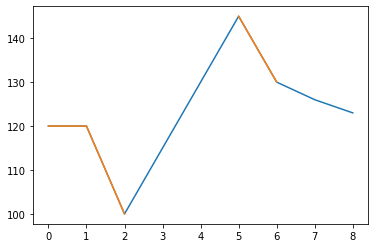

In [6]:
# Para calcular Mediana, AUC e AUC PP é preciso que os valores NaNs sejam tratados, pois do contrário
# o cálculo não é realizado. 
# Aqui tem as funções para interpolar as medidas faltantes e desenhar uma reta entre os pontos. E, é preciso 
# tratar de forma diferente os NanS da 1a. e última coluna.
# Com esses valores preenchidos, é possível calcular a AUC
#

def olha_pra_tras(linha, indice):
    """devolve o último índice e  valores válidos, antes do indice recebido """
    indice = indice - 1

    # pd.Series: precisa do iloc para funcionar com indices negativos
    while math.isnan(linha.iloc[indice]):
        indice -= 1
    return indice, linha.iloc[indice]

def olha_pra_frente(linha, indice):
    """devolve o próximo índice e  valores válidos, antes do indice recebido, "dando a volta" depois do último """
    indice = indice + 1

    # pd.Series: precisa do iloc para funcionar com indices negativos
    while math.isnan(linha.iloc[indice % len(linha)]):
        indice += 1
    return indice, linha.iloc[indice % len(linha)]


def interpola_sem_as_pontas(linha):
    """Dada uma ou mais medidas contendo NaN, interpola
    valores ligando uma reta entre as medidas imediatamente
    anterior e posterior à lacuna
    """
    linha = linha.copy()
    inicio_lacuna = None
    ultimo_valor_valido = None
    ultimo_indice_valido = None
    valor_anterior = 0
    

    
    for indice, valor in enumerate(linha):
        if math.isnan(valor):
            if indice == 0:
                # caso especial - tem que interpolar com valores de antes das 9h00
                pass
            elif inicio_lacuna is not None:
                pass
            else:
                # Primeiro NaN em uma lacuna
                ultimo_valor_valido = valor_anterior
                ultimo_indice_valido = indice - 1
                inicio_lacuna = indice
        elif inicio_lacuna is not None:
            # primeiro número encontrado após uma lacuna
            b = ultimo_valor_valido
            a = (valor - ultimo_valor_valido) / (indice - ultimo_indice_valido)
            for j in range(ultimo_indice_valido + 1, indice):
                x = j - ultimo_indice_valido
                linha[j] = a * x + b
                
            
            inicio_lacuna = None
            ultimo_indice_valido = None
                
        valor_anterior = valor
        # para fazer: se termina a linha dentro de uma lacuna
    return linha

def interpola_lacuna(linha, indice_anterior, valor_valido_anterior, indice, valor):
    b = valor_valido_anterior
    a = (valor - b) / (indice - indice_anterior)
    for j in range(indice_anterior + 1, indice):
        x = j - indice_anterior
        linha[j % len(linha)] = int(a * x + b)

def interpola(linha):
    """Dada uma ou mais medidas contendo NaN, interpola
    valores ligando uma reta entre as medidas imediatamente
    anterior e posterior à lacuna
    """
    linha = linha.copy()
    inicio_lacuna = None
    ultimo_valor_valido = None
    ultimo_indice_valido = None
    valor_anterior = 0
    
    for indice, valor in enumerate(linha):
        if math.isnan(valor_anterior) and not math.isnan(valor):
            indice_anterior, valor_valido_anterior = olha_pra_tras(linha, indice)
            interpola_lacuna(linha, indice_anterior, valor_valido_anterior, indice, valor)
            
        valor_anterior = valor
            
    # para fazer: se termina a linha dentro de uma lacuna
    if math.isnan(valor):
        # se o ultimo valor é um nan - o dia acaba dentro de uma lacuna:
        indice, valor = olha_pra_tras(linha, indice)
        
        proximo_indice, proximo_valor = olha_pra_frente(linha, indice)
        interpola_lacuna(linha, indice, valor, proximo_indice, proximo_valor)
        
    return linha
            
    
v1 = pd.Series([120, 120, 100, math.nan, math.nan, 145, 130, math.nan, math.nan])
v2 = interpola(v1)
plt.plot(v2.index, v2)
plt.plot(v1.index, v1)

olha_pra_frente(v1, 4)


In [7]:
#   Identifica os campos de Sist e Diast e aplica a função "Interpola"
dataset_apos_tratamento.loc[:,'sist 9:00':'sist 8:45'] = dataset_apos_tratamento.loc[:,'sist 9:00':'sist 8:45'].apply(interpola, axis=1)
dataset_apos_tratamento.loc[:,'diast 9:00':'diast 8:45'] = dataset_apos_tratamento.loc[:,'diast 9:00':'diast 8:45'].apply(interpola, axis=1)

dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'].head()

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,105.0,108.0,116.0,104.0,106.0,98.0,102.0,107.0,111.0,116.0,...,41.0,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0
1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0


In [8]:
# Identificando dados espúrios no campo altura e descartando
dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['altura'] != '?']

#filtrar nulos em peso e altura
dataset_apos_tratamento = dataset_apos_tratamento[~dataset_apos_tratamento['peso'].isnull() & ~dataset_apos_tratamento['altura'].isnull()]

In [9]:
#  Normalizando Peso e Altura
dataset_apos_tratamento['peso_normalizado'] = dataset_apos_tratamento['peso'].apply(Tratar_Peso)
dataset_apos_tratamento['altura_normalizada'] = dataset_apos_tratamento['altura'].apply(normaliza_float)

In [10]:
#max(dataset_apos_tratamento['peso_normalizado'])
#max(dataset_apos_tratamento['altura_normalizada'].values)


In [11]:
#calculo do IMC
# Inclui coluna de IMC no dataset de entrada
dataset_apos_tratamento['IMC'] = dataset_apos_tratamento.apply(lambda row : IMC(row['peso_normalizado'], row['altura_normalizada']), axis = 1)

In [12]:
# transform Gender M and F to binary 

limpa_coluna_genero = {"genero": {"M": True, "F": False}}
controle = 1
genero0 = dataset['genero']
for i in range(len(genero0)):
    if genero0.iloc[i] != 'M' and genero0.iloc[i] != 'F':
        if controle == 1:
            genero0.iloc[i] = 0
            controle = 0
        else:
            genero0.iloc[i] = 1
            controle = 1

dataset_apos_tratamento['genero'] = genero0

dataset_apos_tratamento = dataset_apos_tratamento.replace(limpa_coluna_genero)

dataset_apos_tratamento["genero"] = dataset_apos_tratamento["genero"].astype(int)
#
#


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
#  Tratar os dados para colcoá-los em classes

# Cálculo do Indice de Massa Corporal:
#         IMC entre 18,0 e 24,9 Kg/m2: normal
#         IMC menor do que 18,0 Kg/m2: baixo peso
#         IMC entre 25,0 e 29,9 Kg/m2: sobrepeso 
#         IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I 
#         IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II 
#         IMC maior do que 40,0 Kg/m2: obesidade grau III  

def faixas_imc(imc):
    classes = ["baixo peso","normal","sobrepeso",
               "obesidade grau I","obesidade grau II","obesidade Grau III"]
    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
        
def faixas_imc_classe(imc):
    classes = [1, 2, 3, 4, 5, 6]
    
    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
    
def faixas_etarias(idade):
    classes = ["Jovens","Adultos","Meia-idade","Idoso", "Ancião","Velhice extrema"]
    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

def faixas_etarias_classe(idade):
    classes = [1, 2, 3, 4, 5, 6]
    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

In [14]:
dataset_apos_tratamento['idade'] = dataset_apos_tratamento['idade'].fillna(-1)
dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['idade'] != -1]

In [15]:
dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['altura_normalizada'] <= 2.5]
dataset_apos_tratamento = pd.concat([dataset_apos_tratamento.loc[:,'numero_identificacao':'altura'],
                                     dataset_apos_tratamento['IMC'],
                                    dataset_apos_tratamento.loc[:,'data_exame':'Picos Diastolica']],
                                    axis=1)

print(len(dataset_apos_tratamento))
# Dataset com IMC e tratamento de Nans com a política de normalização
dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_completos_tratados.csv", 
                        sep=";", encoding="latin1", index=False)

dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_com_tab.csv", 
                        sep="\t", encoding="latin1", index=False)

19263


In [16]:
dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat']

,Hipotensao,Sistolica Isolada,Diastolica Isolada,Dipping,Non Dipping,Extreme Dipping,Reverse Dipping,Morning Surge,Masked,Whitecoat
0,True,False,False,False,False,False,True,False,False,False
1,True,False,False,False,False,False,True,False,False,False
2,True,False,False,False,True,False,False,False,False,True
3,True,False,False,True,False,False,False,False,False,True
4,True,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
19556,True,False,False,True,False,False,False,True,False,True
19557,True,False,False,False,True,False,False,False,False,True
19558,True,False,False,False,True,False,False,False,False,True
19559,True,False,False,False,False,True,False,False,False,False


In [17]:
dataset_por_classes = pd.DataFrame()
dataset_por_classes['numero_identificacao'] = dataset_apos_tratamento['numero_identificacao']
dataset_por_classes['genero'] = dataset_apos_tratamento['genero']
dataset_por_classes['idade'] = dataset_apos_tratamento['idade'].apply(faixas_etarias_classe)
dataset_por_classes['IMC'] = dataset_apos_tratamento['IMC'].apply(faixas_imc_classe)
dataset_por_classes = pd.concat([dataset_por_classes, dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)
for doenca in list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns):
    dataset_por_classes[doenca] = dataset_apos_tratamento[doenca].apply(verdadeiro_falso)
dataset_por_classes

,numero_identificacao,genero,idade,IMC,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,...,Hipotensao,Sistolica Isolada,Diastolica Isolada,Dipping,Non Dipping,Extreme Dipping,Reverse Dipping,Morning Surge,Masked,Whitecoat
0,4,1,6,4,105.0,108.0,116.0,104.0,106.0,98.0,...,1,0,0,0,0,0,1,0,0,0
1,5,1,4,3,103.0,114.0,82.0,104.0,98.0,106.0,...,1,0,0,0,0,0,1,0,0,0
2,6,1,1,3,147.0,148.0,156.0,140.0,130.0,132.0,...,1,0,0,0,1,0,0,0,0,1
3,7,0,2,2,140.0,139.0,142.0,137.0,135.0,177.0,...,1,0,0,1,0,0,0,0,0,1
4,8,1,2,6,113.0,110.0,101.0,108.0,111.0,111.0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19556,21786,1,3,3,163.0,198.0,172.0,148.0,161.0,156.0,...,1,0,0,1,0,0,0,1,0,1
19557,21787,1,3,3,114.0,120.0,164.0,116.0,119.0,126.0,...,1,0,0,0,1,0,0,0,0,1
19558,21788,0,2,4,107.0,110.0,103.0,105.0,108.0,111.0,...,1,0,0,0,1,0,0,0,0,1
19559,21792,0,4,3,94.0,107.0,112.0,124.0,120.0,94.0,...,1,0,0,0,0,1,0,0,0,0


In [18]:
dataset_apos_tratamento['IMC']

0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19556    27.5
19557    26.9
19558    33.3
19559    25.0
19560    30.9
Name: IMC, Length: 19263, dtype: float64

In [19]:
# Dataset com cadastro, IMC e medidas
dataset_cadastro = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                             dataset_apos_tratamento['genero'],dataset_apos_tratamento['idade'],
                             dataset_apos_tratamento['IMC'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com as medidas
dataset_medidas = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com numero identificação e estatísticas
dataset_estatistica = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h']],axis=1)

# Dataset com numero identificação e doenças
dataset_doenca = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Hipotensao':'Normotenso']],axis=1)



In [20]:
dataset_medidas

,numero_identificacao,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,4,105.0,108.0,116.0,104.0,106.0,98.0,102.0,107.0,111.0,...,41.0,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0
1,5,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,6,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,7,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,8,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19556,21786,163.0,198.0,172.0,148.0,161.0,156.0,156.0,138.0,107.0,...,102.0,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0
19557,21787,114.0,120.0,164.0,116.0,119.0,126.0,123.0,122.0,122.0,...,87.0,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0
19558,21788,107.0,110.0,103.0,105.0,108.0,111.0,114.0,144.0,128.0,...,49.0,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0
19559,21792,94.0,107.0,112.0,124.0,120.0,94.0,102.0,113.0,104.0,...,63.0,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0


# Abordagem 1: Cadastro e Medidas como entrada

In [21]:
dataset_cadastro

,numero_identificacao,genero,idade,IMC,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,4,1,94.0,33.2,105.0,108.0,116.0,104.0,106.0,98.0,...,41.0,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0
1,5,1,70.0,29.4,103.0,114.0,82.0,104.0,98.0,106.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,6,1,19.0,25.8,147.0,148.0,156.0,140.0,130.0,132.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,7,0,40.0,24.2,140.0,139.0,142.0,137.0,135.0,177.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,8,1,28.0,40.6,113.0,110.0,101.0,108.0,111.0,111.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19556,21786,1,47.0,27.5,163.0,198.0,172.0,148.0,161.0,156.0,...,102.0,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0
19557,21787,1,49.0,26.9,114.0,120.0,164.0,116.0,119.0,126.0,...,87.0,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0
19558,21788,0,35.0,33.3,107.0,110.0,103.0,105.0,108.0,111.0,...,49.0,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0
19559,21792,0,68.0,25.0,94.0,107.0,112.0,124.0,120.0,94.0,...,63.0,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0


In [22]:
#selecionando variaveis de medidad : sist 9:00 a diast 8:45
#campos sist e diast

#   Gera uma lista com cabeçalhos
ls_cadastro = list(dataset_cadastro.loc[:,'genero':'diast 8:45'].columns)

dados_cadastro_sem_id = dataset_cadastro.loc[:,'genero':'diast 8:45']
#dados_sist_diast = dados_sist_diast.drop(['peso','altura','data_exame'],axis=1)

dados_cadastro_sem_id.head(5)

,genero,idade,IMC,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,1,94.0,33.2,105.0,108.0,116.0,104.0,106.0,98.0,102.0,...,41.0,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0
1,1,70.0,29.4,103.0,114.0,82.0,104.0,98.0,106.0,108.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,1,19.0,25.8,147.0,148.0,156.0,140.0,130.0,132.0,121.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,0,40.0,24.2,140.0,139.0,142.0,137.0,135.0,177.0,148.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,1,28.0,40.6,113.0,110.0,101.0,108.0,111.0,111.0,114.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0


# Trata nulos, quando houver

In [23]:
#  ****** trocar a variável de dados_cadastro_sem_id  para  dados_cadastro_sem_nan

#####################################################################################
#dados_medidas_sem_nan = dados_medidas.fillna(0)

#  Retirar a linha que contém NaN em alguma coluna 
# dados_cadastro_sem_nan = dados_cadastro
# ls_cadastro = list(dados_cadastro_sem_nan.columns)

## Abordagem 1: Número de Clusters gerado pelo k-Means

In [24]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(dados_cadastro_sem_id)
num_otimo_clusters = optimal_number_of_clusters(sum_of_squares)
num_otimo_clusters

Wall time: 2min 55s


7

In [25]:
#convertendo os dados para a clusterização
X = np.array(dados_cadastro_sem_id)

In [26]:
#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=num_otimo_clusters, random_state=42).fit(X)

In [27]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [28]:
#incluir grupos nos dados de sist e diast
dados_cadastro_sem_id['grupo'] = grupos
dados_cadastro_sem_id['grupo'] = dados_cadastro_sem_id['grupo'] + 1
dados_cadastro_sem_id


,genero,idade,IMC,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,...,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45,grupo
0,1,94.0,33.2,105.0,108.0,116.0,104.0,106.0,98.0,102.0,...,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0,1
1,1,70.0,29.4,103.0,114.0,82.0,104.0,98.0,106.0,108.0,...,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0,4
2,1,19.0,25.8,147.0,148.0,156.0,140.0,130.0,132.0,121.0,...,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0,6
3,0,40.0,24.2,140.0,139.0,142.0,137.0,135.0,177.0,148.0,...,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0,6
4,1,28.0,40.6,113.0,110.0,101.0,108.0,111.0,111.0,114.0,...,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19556,1,47.0,27.5,163.0,198.0,172.0,148.0,161.0,156.0,156.0,...,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0,7
19557,1,49.0,26.9,114.0,120.0,164.0,116.0,119.0,126.0,123.0,...,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0,2
19558,0,35.0,33.3,107.0,110.0,103.0,105.0,108.0,111.0,114.0,...,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0,4
19559,0,68.0,25.0,94.0,107.0,112.0,124.0,120.0,94.0,102.0,...,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0,5


## Abordagem 1: O método Elbow

### Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico

### https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

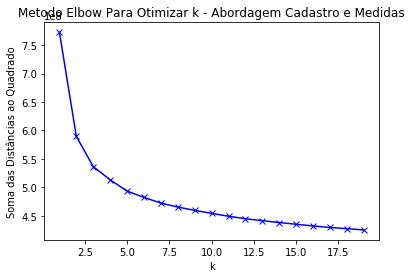

Wall time: 78.1 ms


In [29]:
#metodo de Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Cadastro e Medidas')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_cadastro.svg', format="svg")
%time plt.show()

In [30]:
#fig.savefig('D:\Projeto_PA\\Projeto_PA_validado\\KMeansRandom\\graficos\\grafico_metodoelbow_medidas.svg', format='svg')
#plt.savefig(DIR_NMF / f'NMF_classificado_{grupo}.svg',format="svg")
#fig.savefig('diastolica_sistolica/diast_sist_elbow.png', format='png')


# Abordagem 1: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.2044922805277595
Para n_clusters = 3 O score_silhouette medio e : 0.12703750364796387
Para n_clusters = 4 O score_silhouette medio e : 0.08215749318811917
Para n_clusters = 5 O score_silhouette medio e : 0.07785527558531888
Para n_clusters = 6 O score_silhouette medio e : 0.060742828782366046
Para n_clusters = 7 O score_silhouette medio e : 0.05833719583073113
Para n_clusters = 8 O score_silhouette medio e : 0.05466434823899584


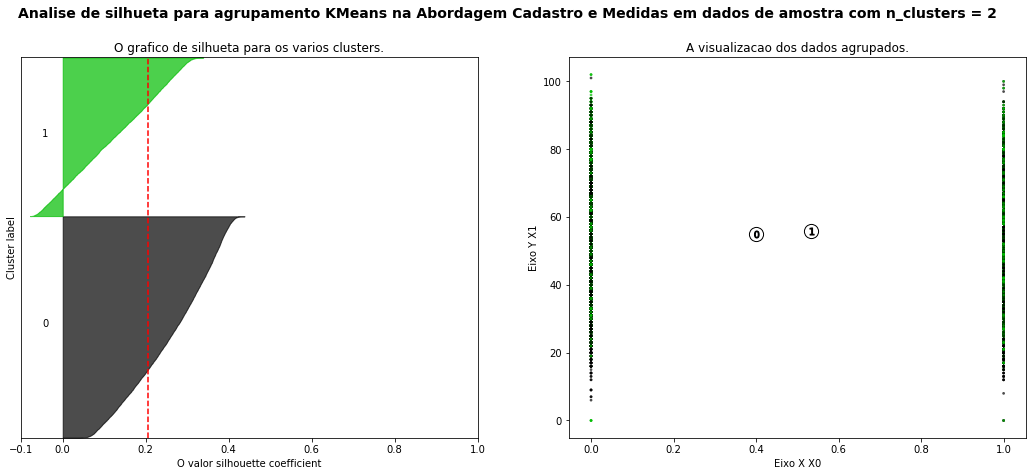

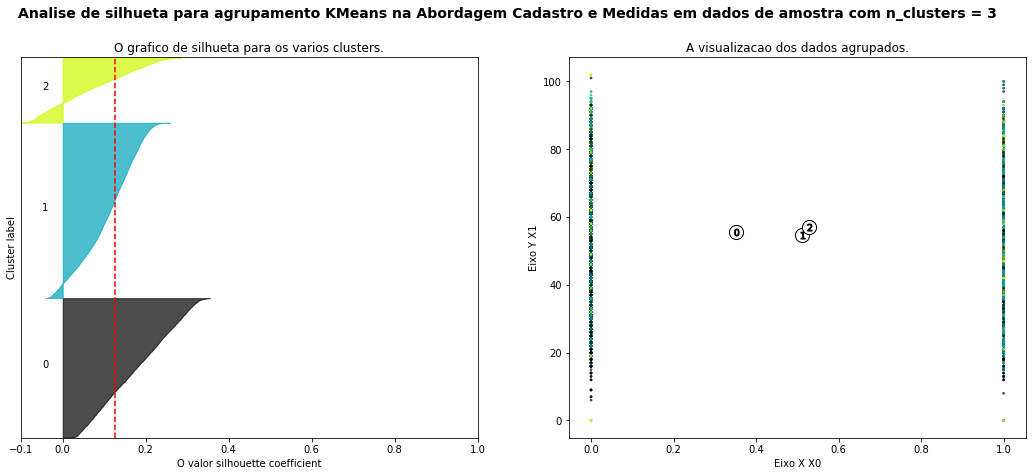

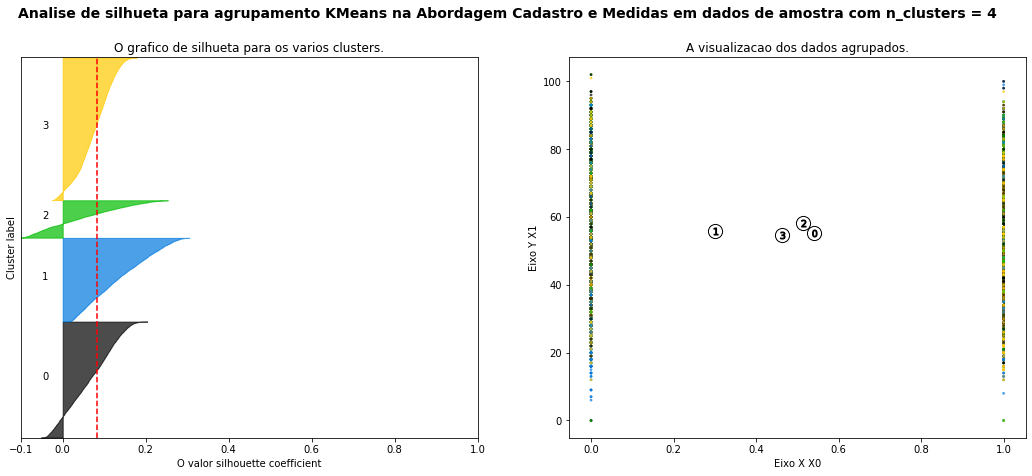

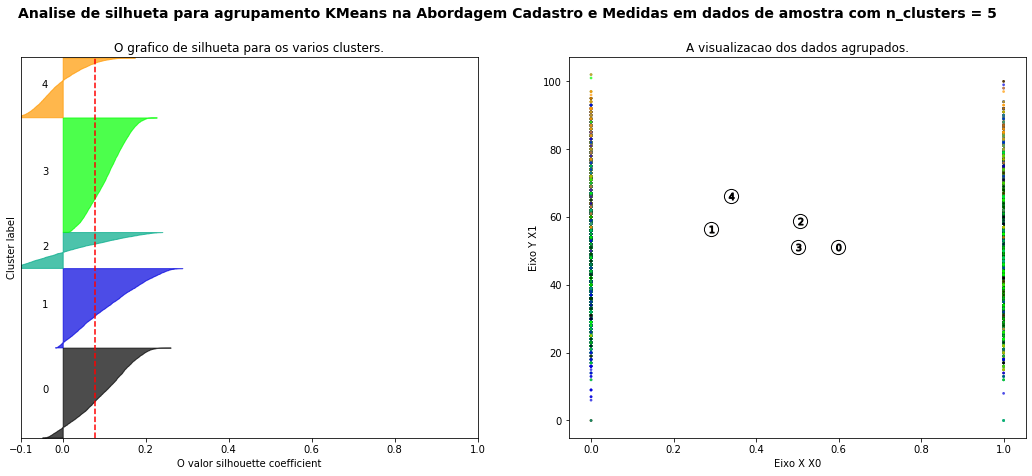

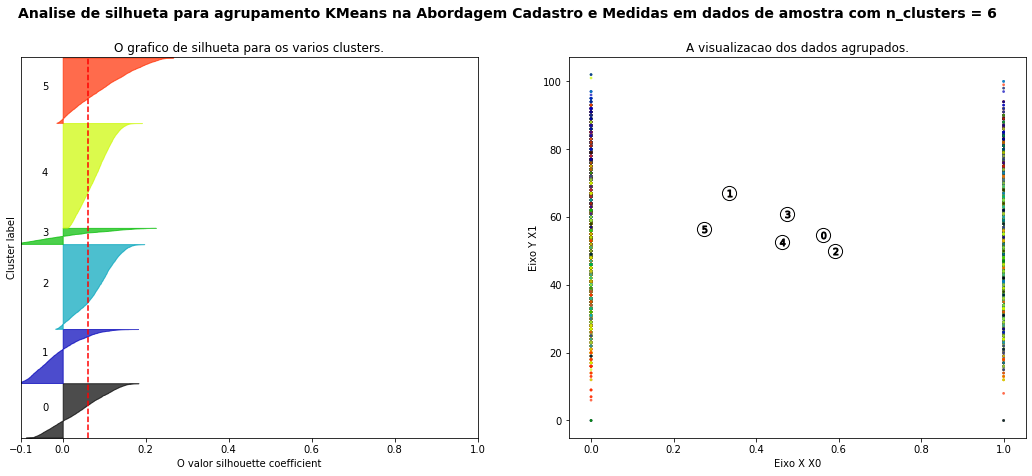

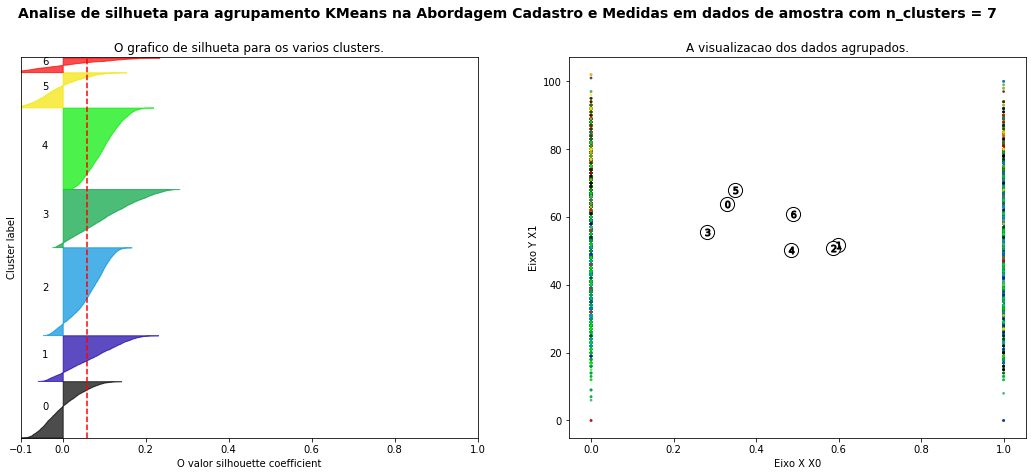

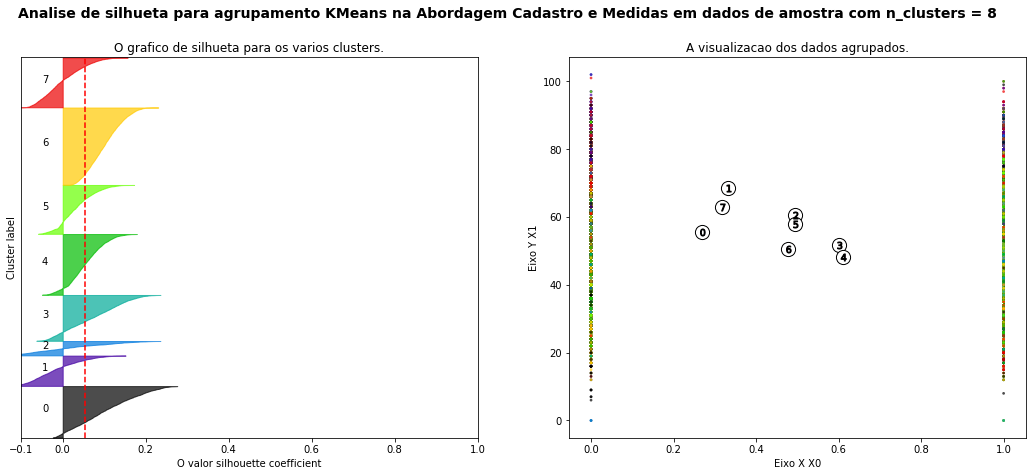

In [31]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans na Abordagem Cadastro e Medidas em dados de amostra "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_cadastro_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando 

In [32]:
#dataset com grupos e com os dados de cadastro e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estaitsticos, 11 doenças em cada grupo 
dataset_s_d = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
dataset_s_d['IMC'] = dataset_cadastro['IMC']
dataset_s_d['grupo'] = grupos
dataset_s_d = pd.concat([dataset_s_d,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_s_d

# Salva dataset com dados completos após o K-Means com abordagem 1 (cadastro e medidas)
dataset_s_d.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

In [33]:
dataset_s_d.head()

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,grupo,sist 9:00,sist 9:15,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
0,4,1923-10-05,1,94.0,85.0,160,33.2,0,105.0,108.0,...,118.5,59.0,9545.5,4902.0,3748.0,841.5,16.52,11.36,11,34
1,5,1948-10-07,1,70.0,80.0,165,29.4,3,103.0,114.0,...,106.0,62.0,8586.5,5034.5,2915.0,606.0,7.51,6.65,9,23
2,6,1999-03-23,1,19.0,100.0,197,25.8,5,147.0,148.0,...,133.0,79.0,10674.0,6154.0,3721.0,751.5,12.70,13.01,19,19
3,7,1978-01-26,0,40.0,65.0,"1,64",24.2,5,140.0,139.0,...,131.0,80.0,10679.5,6420.5,3642.0,602.5,16.13,10.34,21,9
4,8,1990-03-07,1,28.0,120.0,172,40.6,4,113.0,110.0,...,115.0,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11


## Abordagem 1: Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
#parametro simples do modelo
%time random_forest = RandomForestClassifier(n_estimators=50)

Wall time: 0 ns


In [36]:
#base para modelo

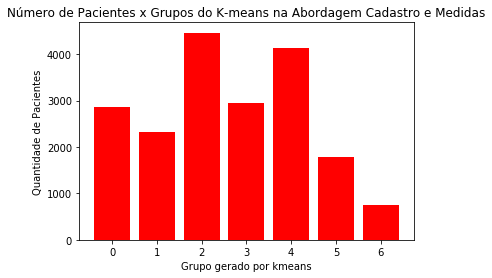

In [37]:
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,num_otimo_clusters):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Cadastro e Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [38]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [39]:
#treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 1: VALIDAÇÃO

In [40]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [41]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [42]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6
0,1684,0,0,0,0,0,0
1,0,1386,0,0,0,0,0
2,0,0,2722,0,0,0,0
3,0,0,0,1773,0,0,0
4,0,0,0,0,2480,0,0
5,0,0,0,0,0,1061,0
6,0,0,0,0,0,0,451


#### Abordagem 1: TESTE

In [43]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [44]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9100700752660265 - Recall: 0.8916870380533377 - F1 Score: 0.9069162376446643


In [45]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6
0,1033,0,44,32,68,8,0
1,0,843,85,0,0,8,1
2,17,10,1674,0,33,7,0
3,23,0,0,1111,45,0,0
4,28,0,69,27,1526,0,0
5,49,23,67,0,0,582,1
6,0,42,0,0,0,6,244


In [46]:
dataset_s_d.describe()


,numero_identificacao,genero,idade,peso,IMC,grupo,sist 9:00,sist 9:15,sist 9:30,sist 9:45,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
count,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,...,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000
mean,10812.522089,0.455485,55.415148,78.081763,28.133084,2.595546,126.659243,126.925816,126.937756,126.885895,...,122.303198,77.179749,9946.691559,6222.013939,3072.503582,604.899263,12.918337,10.579567,16.194622,20.637803
std,6303.030804,0.498027,15.981087,31.196916,10.130514,1.680136,17.564680,17.632750,17.514360,17.408606,...,11.698691,9.957123,943.022167,766.841357,616.165223,122.729940,3.471227,2.308313,13.090004,13.838598
min,4.000000,0.000000,0.000000,4.000000,1.400000,0.000000,60.000000,60.000000,61.000000,62.000000,...,84.500000,43.000000,6903.000000,3651.500000,1641.500000,281.500000,4.570000,3.980000,0.000000,0.000000
25%,5336.500000,0.000000,43.000000,65.000000,24.600000,1.000000,115.000000,115.000000,115.000000,115.000000,...,114.000000,70.000000,9298.500000,5695.750000,2629.500000,519.500000,10.490000,8.960000,7.000000,11.000000
50%,10726.000000,0.000000,55.000000,75.000000,27.200000,2.000000,125.000000,126.000000,125.000000,125.000000,...,121.000000,77.000000,9863.500000,6188.500000,2975.000000,587.000000,12.390000,10.380000,12.000000,17.000000
75%,16283.500000,1.000000,68.000000,87.000000,30.400000,4.000000,137.000000,137.000000,137.000000,137.000000,...,129.000000,84.000000,10481.000000,6706.500000,3412.000000,669.500000,14.790000,11.960000,21.000000,27.000000
max,21793.000000,1.000000,102.000000,1134.000000,432.000000,6.000000,267.000000,265.000000,257.000000,243.000000,...,190.000000,138.500000,15230.000000,11134.500000,7329.500000,1418.500000,39.550000,24.390000,81.000000,82.000000


In [47]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_s_d, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_s_d, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 1: Importância das Features Random Forest

In [48]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_cadastro,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('features')

In [49]:
importancia


,importance
features,
sist 6:45,0.017
sist 6:15,0.015
sist 20:30,0.013
diast 11:30,0.011
diast 11:45,0.010
...,...
diast 22:45,0.003
diast 22:30,0.003
diast 2:00,0.002


In [50]:
#importances.to_excel('diastolica_sistolica/features_sisto_diasto.xlsx')

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')



## Abordagem 2: Medidas como entrada

In [51]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45

#   Gera uma lista com cabeçalhos
ls_sist_diast = list(dataset_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dados_medidas_sem_id = dataset_medidas.loc[:,'sist 9:00':'diast 8:45']

#dados_medidas_sem_id.head(5)
dados_medidas_sem_id.loc[1:70]


,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0
5,152.0,152.0,152.0,152.0,154.0,138.0,137.0,152.0,95.0,117.0,...,67.0,94.0,120.0,109.0,109.0,110.0,111.0,112.0,114.0,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,80.0,80.0,85.0,96.0,106.0,105.0,103.0,105.0,104.0,100.0,...,59.0,60.0,61.0,60.0,60.0,55.0,61.0,47.0,49.0,45.0
67,113.0,119.0,120.0,122.0,117.0,122.0,118.0,122.0,126.0,133.0,...,85.0,85.0,85.0,86.0,87.0,62.0,63.0,86.0,81.0,84.0
68,154.0,142.0,123.0,125.0,111.0,113.0,114.0,118.0,113.0,121.0,...,67.0,78.0,89.0,97.0,82.0,87.0,96.0,100.0,83.0,85.0
69,118.0,122.0,116.0,115.0,84.0,102.0,120.0,118.0,116.0,115.0,...,68.0,68.0,67.0,56.0,62.0,66.0,73.0,66.0,72.0,75.0


### Tratar nulos, quando houver

In [52]:
#  Retirar a linha que contém NaN em alguma coluna 
#  ****** trocar a variável de dados_medidas_sem_id  para  dados_medidas_sem_nan

#####################################################################################

#dados_medidas_sem_nan = dados_medidas_sem_id.fillna(0)



## Abordagem 2: Número de Clusters gerado pelo k-Means

In [53]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(dados_medidas_sem_id)
num_otimo_clusters = optimal_number_of_clusters(sum_of_squares)
num_otimo_clusters

Wall time: 2min 49s


7

In [54]:
#convertendo os dados para a clusterização

dados_medidas_array = np.array(dados_medidas_sem_id)

In [55]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans = KMeans(n_clusters=num_otimo_clusters, random_state=42).fit(dados_medidas_array)

In [56]:
#listar os grupos 

%time grupos = kmeans.fit_predict(dados_medidas_array)

Wall time: 6.85 s


In [57]:
#incluir grupos nos dados de sist e diast

dados_medidas_sem_id['grupo'] = grupos
dados_medidas_sem_id['grupo'] = dados_medidas_sem_id['grupo'] + 1
dados_medidas_sem_id

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45,grupo
0,105.0,108.0,116.0,104.0,106.0,98.0,102.0,107.0,111.0,116.0,...,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0,5
1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,...,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0,5
2,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,...,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0,4
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,...,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0,4
4,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,...,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19556,163.0,198.0,172.0,148.0,161.0,156.0,156.0,138.0,107.0,76.0,...,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0,2
19557,114.0,120.0,164.0,116.0,119.0,126.0,123.0,122.0,122.0,159.0,...,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0,6
19558,107.0,110.0,103.0,105.0,108.0,111.0,114.0,144.0,128.0,104.0,...,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0,5
19559,94.0,107.0,112.0,124.0,120.0,94.0,102.0,113.0,104.0,96.0,...,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0,7


##  Abordagem 2: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

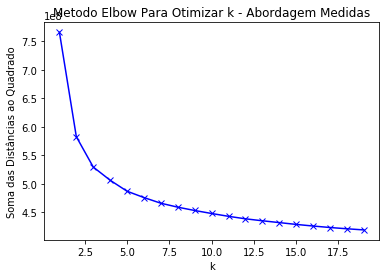

Wall time: 66.2 ms


In [58]:
#metodo de Elbow

Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dados_medidas_array)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Medidas')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medida.svg', format="svg")
%time plt.show()

# Abordagem 2: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.20602427585848174
Para n_clusters = 3 O score_silhouette medio e : 0.12821614294094277
Para n_clusters = 4 O score_silhouette medio e : 0.08315508556372023
Para n_clusters = 5 O score_silhouette medio e : 0.07920433641353515
Para n_clusters = 6 O score_silhouette medio e : 0.06158869162251573
Para n_clusters = 7 O score_silhouette medio e : 0.05928599418906495
Para n_clusters = 8 O score_silhouette medio e : 0.05547577358394885


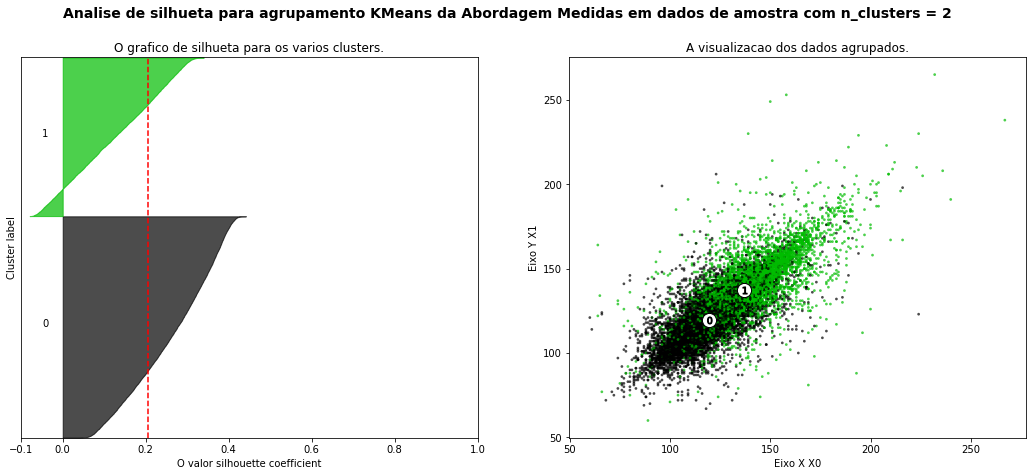

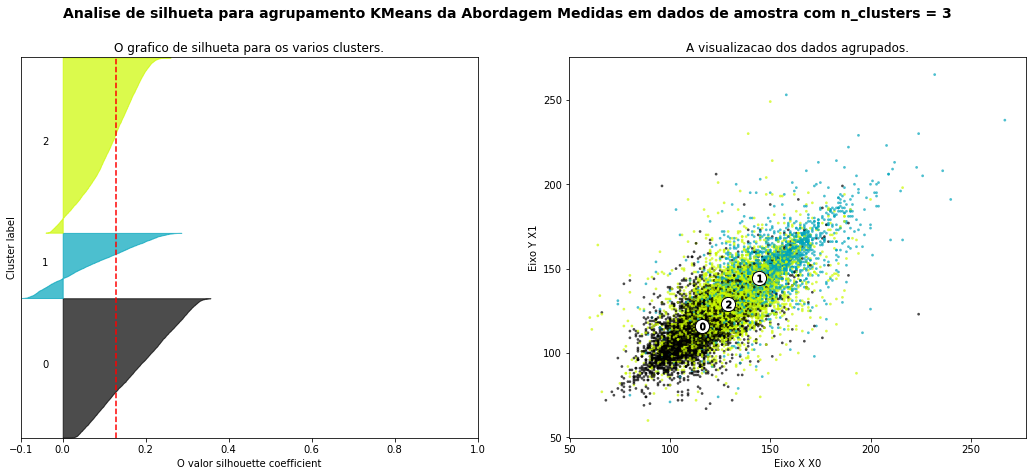

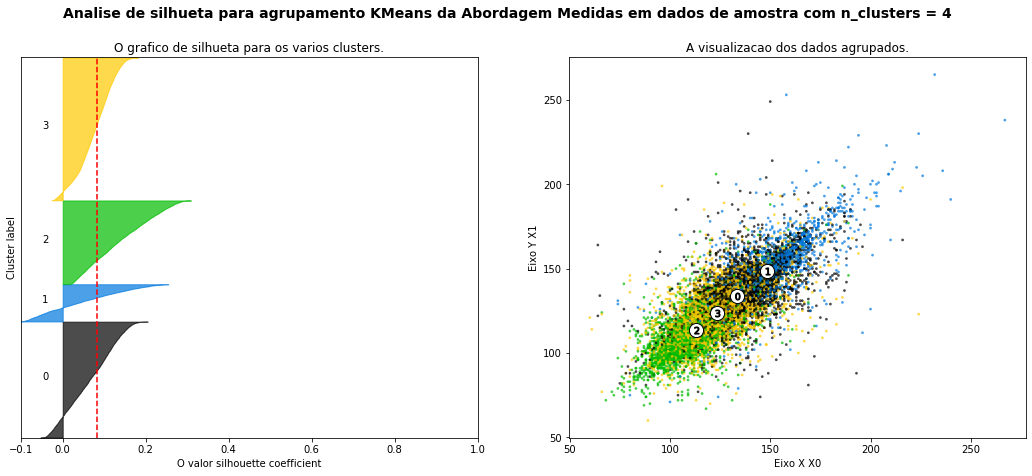

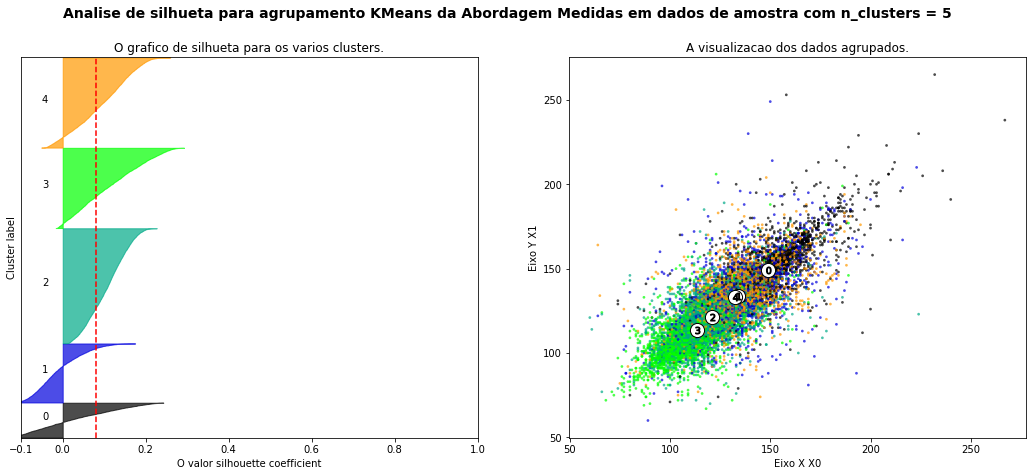

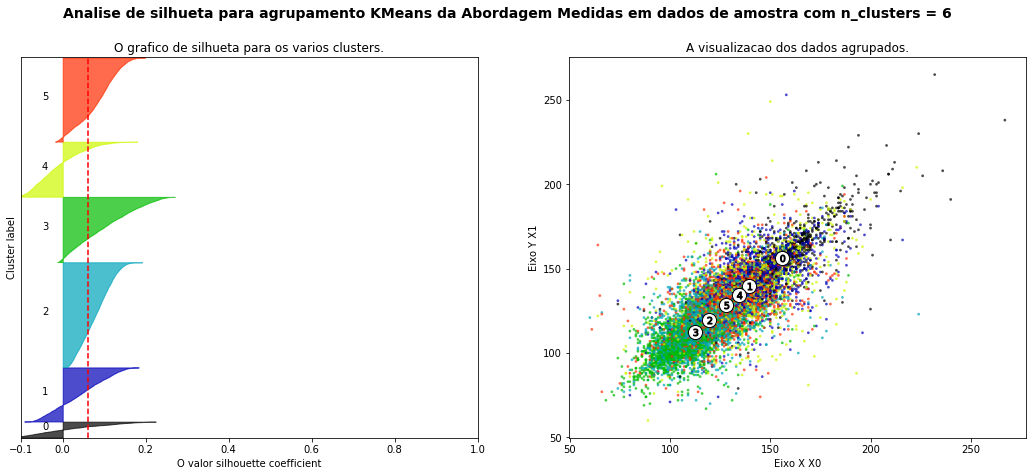

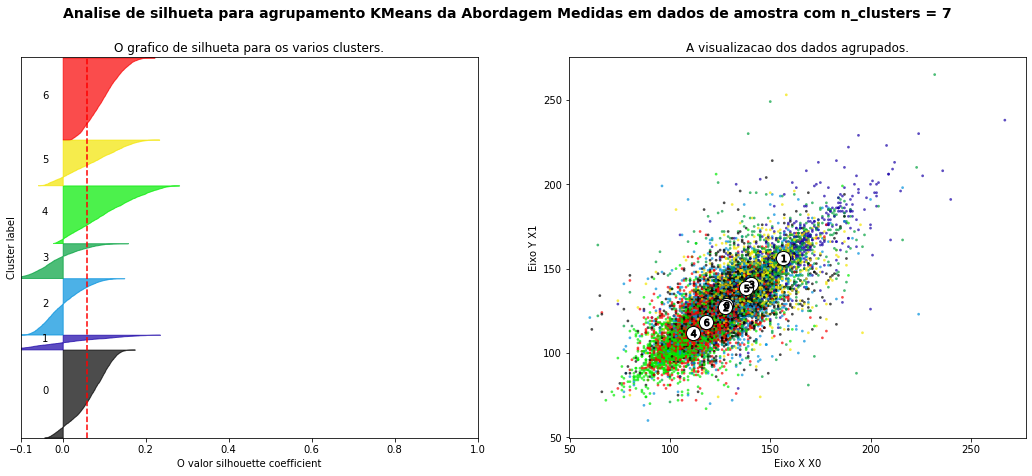

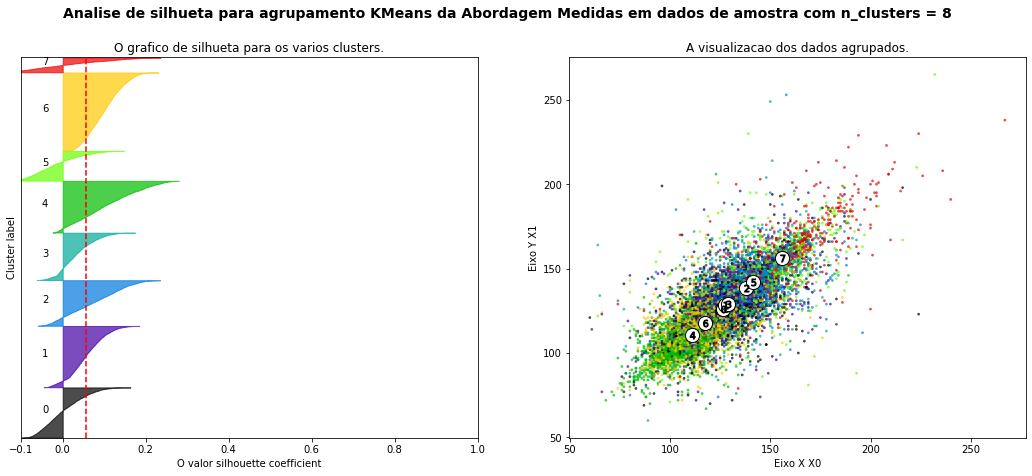

In [59]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dados_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dados_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dados_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dados_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dados_medidas_array[:, 0], dados_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Medidas em dados de amostra "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [60]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
dataset_medidas_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']

dataset_medidas_apos_kmeans['grupo'] = grupos
dataset_medidas_apos_kmeans = pd.concat([dataset_medidas_apos_kmeans,
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_medidas_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_medidas_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

In [61]:
dataset_medidas_apos_kmeans.head()

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,grupo,sist 9:00,sist 9:15,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
0,4,1923-10-05,1,94.0,85.0,160,33.2,4,105.0,108.0,...,118.5,59.0,9545.5,4902.0,3748.0,841.5,16.52,11.36,11,34
1,5,1948-10-07,1,70.0,80.0,165,29.4,4,103.0,114.0,...,106.0,62.0,8586.5,5034.5,2915.0,606.0,7.51,6.65,9,23
2,6,1999-03-23,1,19.0,100.0,197,25.8,3,147.0,148.0,...,133.0,79.0,10674.0,6154.0,3721.0,751.5,12.70,13.01,19,19
3,7,1978-01-26,0,40.0,65.0,"1,64",24.2,3,140.0,139.0,...,131.0,80.0,10679.5,6420.5,3642.0,602.5,16.13,10.34,21,9
4,8,1990-03-07,1,28.0,120.0,172,40.6,6,113.0,110.0,...,115.0,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11


### Abordagem 2: Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

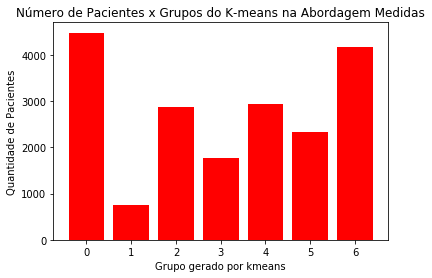

In [64]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,num_otimo_clusters):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [65]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_array, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_array, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [66]:
#treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 2: VALIDAÇÃO

In [67]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [68]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [69]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6
0,2731,0,0,0,0,0,0
1,0,452,0,0,0,0,0
2,0,0,1689,0,0,0,0
3,0,0,0,1047,0,0,0
4,0,0,0,0,1763,0,0
5,0,0,0,0,0,1378,0
6,0,0,0,0,0,0,2497


#### Abordagem 2: TESTE

In [70]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [71]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.907734233065144 - Recall: 0.8897081403290908 - F1 Score: 0.9057470855960343


In [72]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6
0,1674,0,13,7,0,12,38
1,0,242,0,8,0,43,0
2,50,0,1016,7,32,0,70
3,67,0,39,598,0,17,0
4,0,0,26,0,1086,0,53
5,93,1,0,7,0,840,0
6,72,0,20,0,36,0,1539


In [73]:
dataset_medidas_apos_kmeans.describe()


,numero_identificacao,genero,idade,peso,IMC,grupo,sist 9:00,sist 9:15,sist 9:30,sist 9:45,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
count,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,...,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000,19263.000000
mean,10812.522089,0.455485,55.415148,78.081763,28.133084,3.118310,126.659243,126.925816,126.937756,126.885895,...,122.303198,77.179749,9946.691559,6222.013939,3072.503582,604.899263,12.918337,10.579567,16.194622,20.637803
std,6303.030804,0.498027,15.981087,31.196916,10.130514,2.226987,17.564680,17.632750,17.514360,17.408606,...,11.698691,9.957123,943.022167,766.841357,616.165223,122.729940,3.471227,2.308313,13.090004,13.838598
min,4.000000,0.000000,0.000000,4.000000,1.400000,0.000000,60.000000,60.000000,61.000000,62.000000,...,84.500000,43.000000,6903.000000,3651.500000,1641.500000,281.500000,4.570000,3.980000,0.000000,0.000000
25%,5336.500000,0.000000,43.000000,65.000000,24.600000,1.000000,115.000000,115.000000,115.000000,115.000000,...,114.000000,70.000000,9298.500000,5695.750000,2629.500000,519.500000,10.490000,8.960000,7.000000,11.000000
50%,10726.000000,0.000000,55.000000,75.000000,27.200000,3.000000,125.000000,126.000000,125.000000,125.000000,...,121.000000,77.000000,9863.500000,6188.500000,2975.000000,587.000000,12.390000,10.380000,12.000000,17.000000
75%,16283.500000,1.000000,68.000000,87.000000,30.400000,5.000000,137.000000,137.000000,137.000000,137.000000,...,129.000000,84.000000,10481.000000,6706.500000,3412.000000,669.500000,14.790000,11.960000,21.000000,27.000000
max,21793.000000,1.000000,102.000000,1134.000000,432.000000,6.000000,267.000000,265.000000,257.000000,243.000000,...,190.000000,138.500000,15230.000000,11134.500000,7329.500000,1418.500000,39.550000,24.390000,81.000000,82.000000


In [74]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 2: Importância das Features Random Forest

In [75]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('features')

In [76]:
importancia

,importance
features,
sist 6:15,0.016
sist 6:45,0.014
diast 13:00,0.012
sist 19:15,0.011
sist 20:30,0.011
...,...
diast 22:45,0.003
diast 23:00,0.003
diast 6:00,0.002


In [77]:
#importances.to_excel('diastolica_sistolica/features_sisto_diasto.xlsx')

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')



## Features Selection: Select Kbest na Abordagem 2

In [78]:
#  Uso do SelectKBest para identificar as melhores 5 features

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

medidas_mais_importantes_ml = SelectKBest(chi2, k=7).fit_transform(dados_medidas_array, grupos)
medidas_mais_importantes_ml.shape

(19263, 7)

In [79]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

medidas_mais_importantes = pd.DataFrame(medidas_mais_importantes_ml)

In [80]:
# identificação de quais colunas foram escolhidas

############################################################################################
#
lista_colunas_escolhidas = []
#
## X é o dataset das doenças que precisa ser transformado em df
medidas_transformadas = pd.DataFrame(dados_medidas_array)

##medidas_transformadas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'kbest.csv', 
#             sep=';',index=False,encoding='UTF-8')
#
for coluna_ml in range(len(medidas_mais_importantes.columns)):
    for coluna_base in range(len(medidas_transformadas.columns)):
        # para identificar valores únicos
        if set(np.array(medidas_transformadas[coluna_base]) == np.array(medidas_mais_importantes[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas

## Foram escolhidas as colunas sist 5:30, sist 6:00, sist 6:15, sist 6:30, sist 6:45, sist 7:00, sist 7:15, sist 7:30
#

[70, 71, 72, 73, 74, 75, 76]

In [81]:
#selecionando padrões de doencas

ls_medidas_kbest = ['sist 5:30', 'sist 6:00', 'sist 6:15', 'sist 6:30', 'sist 6:45', 'sist 7:00', 'sist 7:15']

dados_padrao_medidas_kbest =  dataset_apos_tratamento[ls_medidas_kbest]

### K-means para SelectKbest

In [82]:
#  Cálculo do "n_clusters" considerando as colunas definidas por SelectKBest

sum_of_squares = calculate_wcss(medidas_mais_importantes_ml)
medidas_kbest = optimal_number_of_clusters(sum_of_squares)
kmeans = KMeans(n_clusters=medidas_kbest, random_state=42).fit(medidas_mais_importantes_ml)
grupos_medidas = kmeans.fit_predict(medidas_mais_importantes_ml)
print(medidas_kbest)
print(grupos_medidas)

6
[5 1 2 ... 5 1 5]


###  Abordagem 2,5: Random Forest for KBest

In [83]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

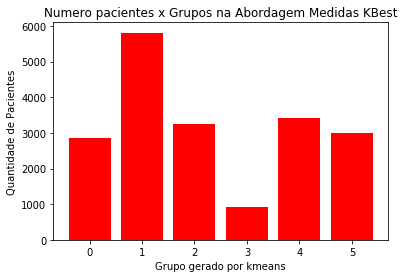

In [84]:
#base para modelo
classes = []
qtds = []

contagem_medidas = Counter(grupos_medidas)

for i in range(0,medidas_kbest):
    classes.append(i)
    qtds.append(contagem_medidas[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos na Abordagem Medidas KBest')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem2_medidasKBest_por_grupos.svg',format="svg")
plt.show()

## Train, Test, Validation for KBest

In [85]:
# Separa o grupo de dados para treino e teste
#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection: SelectKBest
x_train, x_test, y_train, y_test = train_test_split(medidas_mais_importantes_ml, grupos_medidas, test_size=1 - train_ratio,random_state=42)

# Feature Selection: SelectKBest
x_val, x_test, y_val, y_test = train_test_split(medidas_mais_importantes_ml, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)


# Feature Selection: SelectKBest sem validação
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)

#X_train.shape, y_train.shape

#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [86]:
# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 2,5: VALIDAÇÃO

In [87]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [88]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5
0,1694,0,0,0,0,0
1,0,3530,0,0,0,0
2,0,0,1946,0,0,0
3,0,0,0,570,0,0
4,0,0,0,0,1995,0
5,0,0,0,0,0,1822


#### Abordagem 2,5: TESTE

In [89]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9679470542434466 - Recall: 0.965173825972026 - F1 Score: 0.9684852592642438


In [90]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5
0,1137,0,13,5,17,0
1,0,2243,11,0,8,19
2,4,41,1241,0,18,1
3,14,0,0,345,0,0
4,15,16,20,0,1367,0
5,0,45,0,0,0,1126


####  Abordagem 2,5: Importância das Features Random Forest

In [91]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

# Importância para SelctKBest
importancia_medidas = pd.DataFrame({'features':ls_medidas_kbest,'importance':np.round(random_forest.feature_importances_,3)})

importancia_medidas = importancia_medidas.sort_values('importance',ascending=False).set_index('features')

importancia_medidas

,importance
features,
sist 6:00,0.210
sist 6:30,0.198
sist 7:00,0.156
sist 7:15,0.152
sist 6:45,0.113
sist 6:15,0.101
sist 5:30,0.070


In [92]:
importancia_medidas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_kbest_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

# Abordagem 3: Estatísticas como entrada

In [93]:
#selecionando variaveis estatisticas


ls_estatistica = [
    'Media Sistolica em 24h',
#    'Media Diastolica em 24h',
#    'Media Sistolica Diurna',
#    'Media Sistolica Matutina',
#    'Media Sistolica Vespertina',
#    'Media Sistolica Daytime',
#    'Media Sistolica Nighttime',
#    'Media Diastolica Diurna',
#    'Media Diastolica Matutina',
#    'Media Diastolica Vespertina',
#    'Media Diastolica Daytime',
#    'Media Diastolica Nighttime',
#    'Variancia Sistolica em 24h',
#    'Variancia Diastolica em 24h',
#    'Mediana Sistolica em 24h',
#    'Mediana Diastolica em 24h',
    'AUC Sistolica em 24h',
    'AUC Diastolica em 24h',
    'AUC PP Daytime',
#    'AUC PP Nighttime',
#    'DP Sistolica em 24h',
#    'DP Diastolica em 24h',
]

dados_estatistica =  dataset_estatistica[ls_estatistica]

In [94]:
#tratar nulos
dados_estatistica_sem_nan = dados_estatistica.fillna(0)

## Abordagem 3: Número de Clusters gerado pelo k-Means

In [95]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(dados_estatistica_sem_nan)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

Wall time: 32.3 s
7


In [96]:
#convertendo os dados para a clusterização
X = np.array(dados_estatistica_sem_nan)

In [97]:
#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=42).fit(X)

In [98]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [99]:
#incluir grupos nos dados de sist e diast
dados_estatistica_sem_nan['grupo'] = grupos
dados_estatistica_sem_nan['grupo'] = dados_estatistica_sem_nan['grupo'] + 1

##   Abordagem 3: Método Elbow 

###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

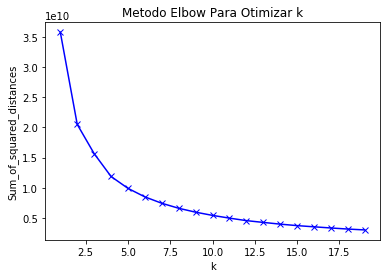

In [100]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_estatistica.svg', format="svg")
plt.show()



# Abordagem 3: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.38518647123107935
Para n_clusters = 3 O score_silhouette medio e : 0.3260097577207089
Para n_clusters = 4 O score_silhouette medio e : 0.3505739776520514
Para n_clusters = 5 O score_silhouette medio e : 0.3260347532613461
Para n_clusters = 6 O score_silhouette medio e : 0.32662397403689497
Para n_clusters = 7 O score_silhouette medio e : 0.3220214333003618


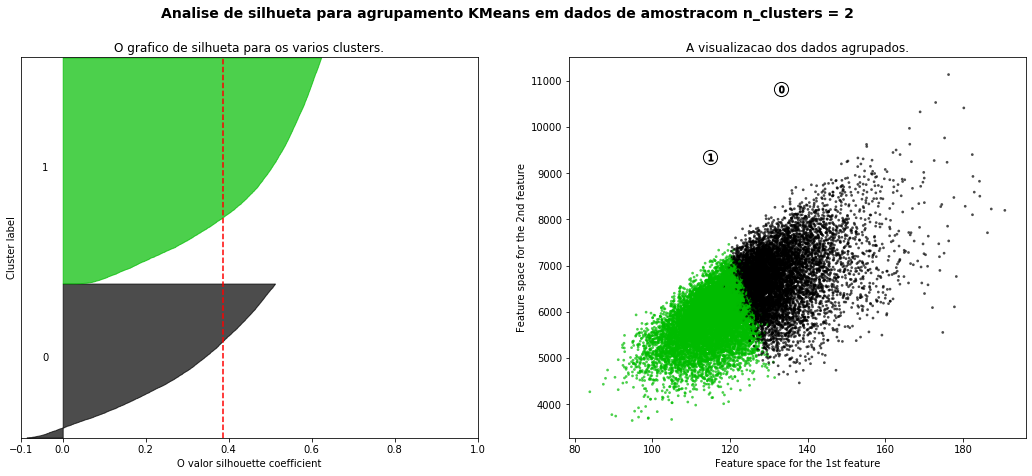

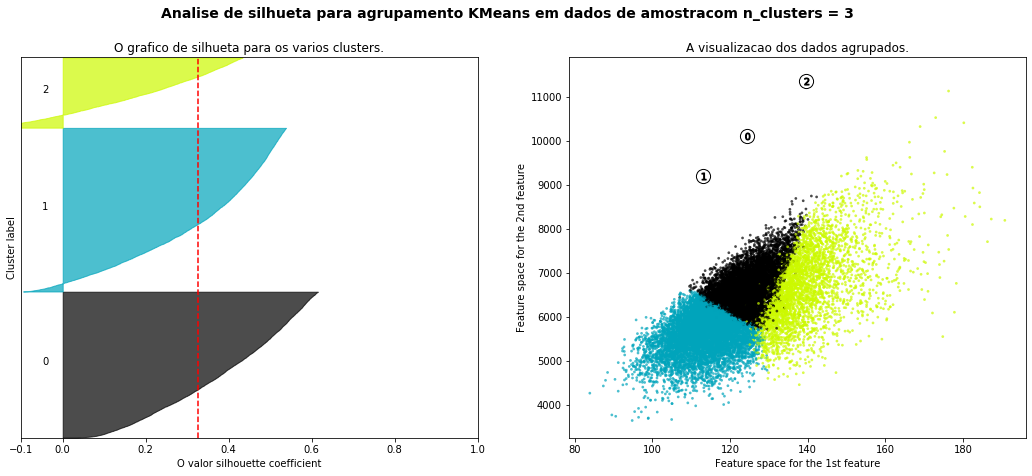

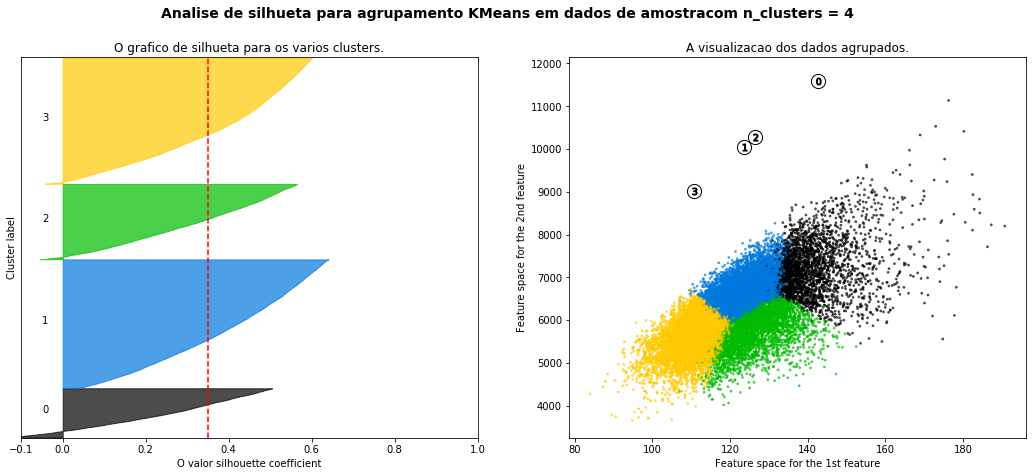

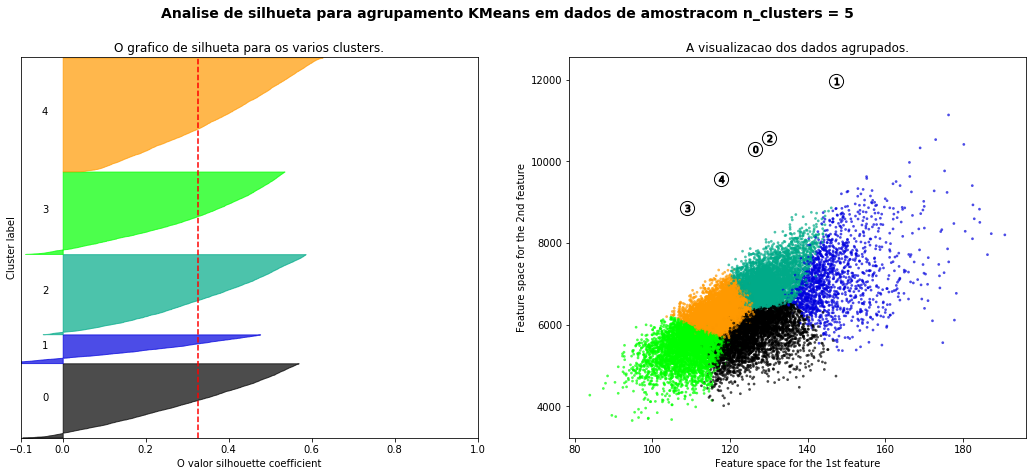

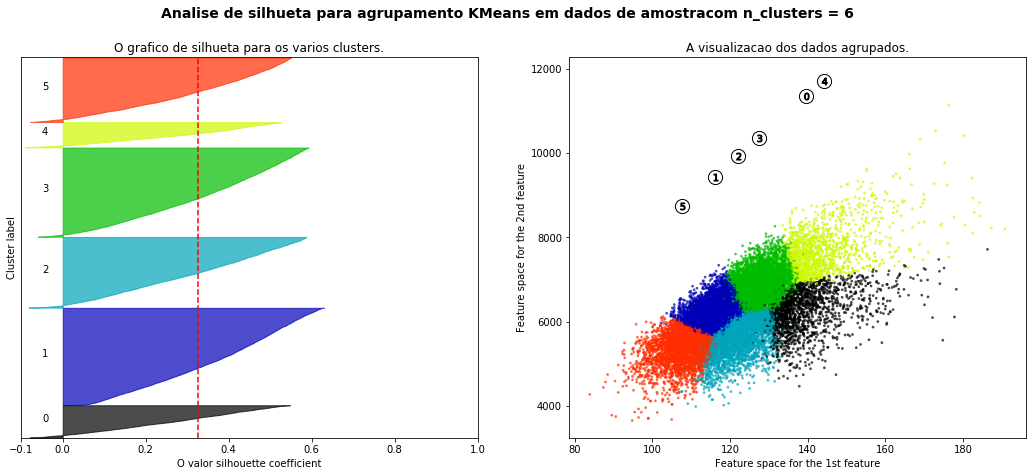

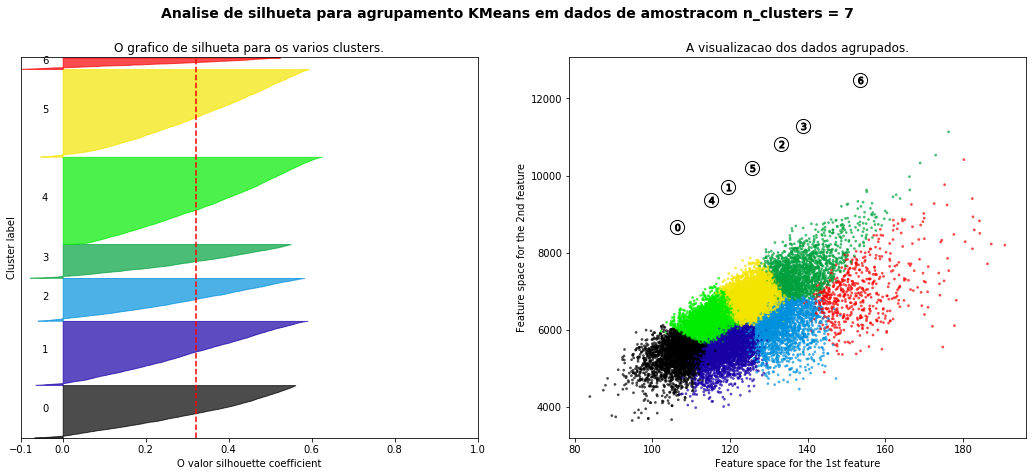

In [101]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans em dados de amostra"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_estatistica_{n_clusters}.svg', format="svg")
    #fig.savefig('estatisticas/estatisticas_kmeans_'+str(n_clusters)+'.png', format='png')

plt.show()

#fig.savefig('kmeans_estatisticas.png', format='png')

In [102]:
#dataset com grupos e por estatisticas

dataset_estatistica = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']
#############################################################################################
#dataset_estatistica = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_estatistica['IMC'] = dataset_medidas['IMC']
dataset_estatistica['grupo'] = grupos
dataset_estatistica = pd.concat([dataset_estatistica,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


### Abordagem 3: Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

In [105]:
#base para modelo

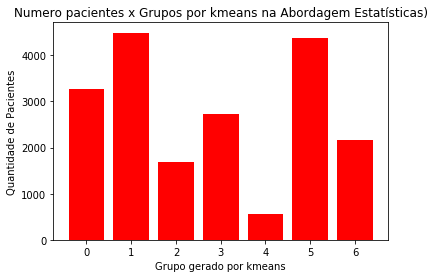

In [106]:
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Estatísticas)')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem2_estatistica_por_grupos.svg',format="svg")
plt.show()

In [107]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [108]:
#treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 3: VALIDAÇÃO

In [109]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [110]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [111]:
#Matriz da Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6
0,1956,0,0,0,0,0,0
1,0,2686,0,0,0,0,0
2,0,0,1020,0,0,0,0
3,0,0,0,1618,0,0,0
4,0,0,0,0,339,0,0
5,0,0,0,0,0,2644,0
6,0,0,0,0,0,0,1294


#### Abordagem 3: TESTE

In [112]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [113]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9893589410848689 - Recall: 0.9885289363799611 - F1 Score: 0.9879783006250635


In [114]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6
0,1291,9,0,2,0,2,5
1,7,1792,0,2,0,3,0
2,0,0,671,0,2,3,1
3,1,5,0,1093,0,0,0
4,0,0,1,0,213,0,1
5,1,5,4,0,0,1720,3
6,9,0,2,0,4,10,844


In [115]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_estatistica = x_val_[['numero_identificacao']]
pacientes_validacao_estatistica['Grupo_Real'] = y_val_
pacientes_validacao_estatistica['Grupo_Previsto'] = y_prev_val
pacientes_validacao_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


#teste
pacientes_teste_estatistica = x_test_[['numero_identificacao']]
pacientes_teste_estatistica['Grupo_Real'] = y_test_
pacientes_teste_estatistica['Grupo_Previsto'] = y_prev_test
pacientes_teste_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 3: Importância das Features Random Forest

In [116]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_estatistica,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('features')

In [117]:
importancia

,importance
features,
AUC Sistolica em 24h,0.319
AUC Diastolica em 24h,0.259
AUC PP Daytime,0.226
Media Sistolica em 24h,0.197


In [118]:
importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


## Abordagem 4: Padrão de Doenças como entrada

In [119]:
#selecionando padrões de doencas

ls_padroes_doencas = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas =  dataset_apos_tratamento[ls_padroes_doencas]

In [120]:
dados_padrao_doencas[dados_padrao_doencas['Non Dipping'] == True]

,Hipotensao,Sistolica Isolada,Diastolica Isolada,Dipping,Non Dipping,Extreme Dipping,Reverse Dipping,Morning Surge,Masked,Whitecoat,Normotenso
2,True,False,False,False,True,False,False,False,False,True,False
5,True,False,False,False,True,False,False,False,False,True,False
6,True,False,False,False,True,False,False,False,False,True,False
7,True,False,False,False,True,False,False,False,False,False,False
8,True,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
19549,True,False,False,False,True,False,False,False,False,True,False
19550,True,False,False,False,True,False,False,False,False,True,False
19552,True,False,False,False,True,False,False,False,False,True,False
19557,True,False,False,False,True,False,False,False,False,True,False


In [121]:
#tratar nulos
dados_padrao_doencas_sem_nan = dados_padrao_doencas.fillna(0)
dados_padrao_doencas_sem_nan

,Hipotensao,Sistolica Isolada,Diastolica Isolada,Dipping,Non Dipping,Extreme Dipping,Reverse Dipping,Morning Surge,Masked,Whitecoat,Normotenso
0,True,False,False,False,False,False,True,False,False,False,False
1,True,False,False,False,False,False,True,False,False,False,False
2,True,False,False,False,True,False,False,False,False,True,False
3,True,False,False,True,False,False,False,False,False,True,False
4,True,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
19556,True,False,False,True,False,False,False,True,False,True,False
19557,True,False,False,False,True,False,False,False,False,True,False
19558,True,False,False,False,True,False,False,False,False,True,False
19559,True,False,False,False,False,True,False,False,False,False,False


In [122]:
#trocar nulos do dataframe
d_p_d = dados_padrao_doencas

In [123]:
##############################################################################################################
#Trocar True e False para 1 e 0
d_p_d['Hipotensao'] = d_p_d['Hipotensao'].apply(verdadeiro_falso)
d_p_d['Sistolica Isolada'] = d_p_d['Sistolica Isolada'].apply(verdadeiro_falso)
d_p_d['Diastolica Isolada'] = d_p_d['Diastolica Isolada'].apply(verdadeiro_falso)
d_p_d['Dipping'] = d_p_d['Dipping'].apply(verdadeiro_falso)
d_p_d['Non Dipping'] = d_p_d['Non Dipping'].apply(verdadeiro_falso)
d_p_d['Extreme Dipping'] = d_p_d['Extreme Dipping'].apply(verdadeiro_falso)
d_p_d['Reverse Dipping'] = d_p_d['Reverse Dipping'].apply(verdadeiro_falso)
d_p_d['Morning Surge'] = d_p_d['Morning Surge'].apply(verdadeiro_falso)
d_p_d['Masked'] = d_p_d['Masked'].apply(verdadeiro_falso)
d_p_d['Whitecoat'] = d_p_d['Whitecoat'].apply(verdadeiro_falso)
d_p_d['Normotenso'] = d_p_d['Normotenso'].apply(verdadeiro_falso)

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

##  Abordagem 4: Número de Clusters gerado pelo k-Means

In [124]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(d_p_d)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

8


In [125]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [126]:
#convertendo os dados para entrga ao Random - Classifcação
X = np.array(d_p_d)

In [127]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans = KMeans(n_clusters=n, random_state=42).fit(X)


In [128]:
#listar os grupos 

grupos = kmeans.fit_predict(X)


In [129]:
grupos

array([3, 3, 0, ..., 0, 4, 3])

In [130]:
print (len(grupos))

19263


In [131]:
set(grupos)

{0, 1, 2, 3, 4, 5, 6, 7}

##   Abordagem 4: Método Elbow 

###  Método de cálculo do melhor número de cluster para o algoritmo e plota o gráfico

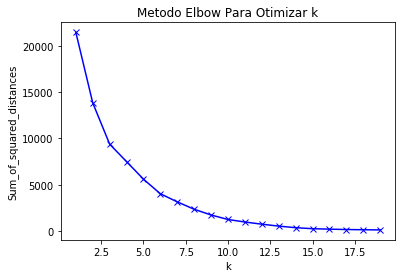

In [132]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf()
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_doenca.svg', format="svg")
plt.show()

# Abordagem 4: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.41713694934984613
Para n_clusters = 3 O score_silhouette medio e : 0.5266703088412095
Para n_clusters = 4 O score_silhouette medio e : 0.584957761829965
Para n_clusters = 5 O score_silhouette medio e : 0.6559249740965658
Para n_clusters = 6 O score_silhouette medio e : 0.6954281872502481
Para n_clusters = 7 O score_silhouette medio e : 0.7505000913058408
Para n_clusters = 8 O score_silhouette medio e : 0.8144532886126473


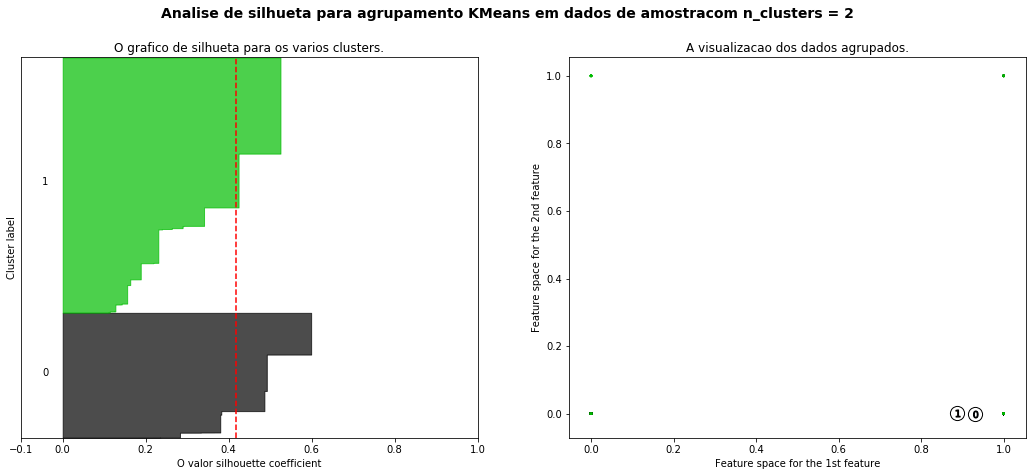

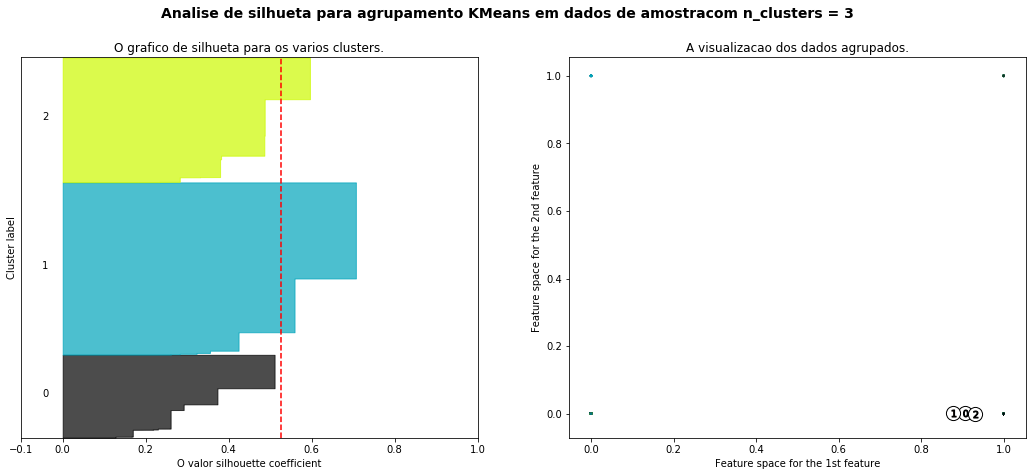

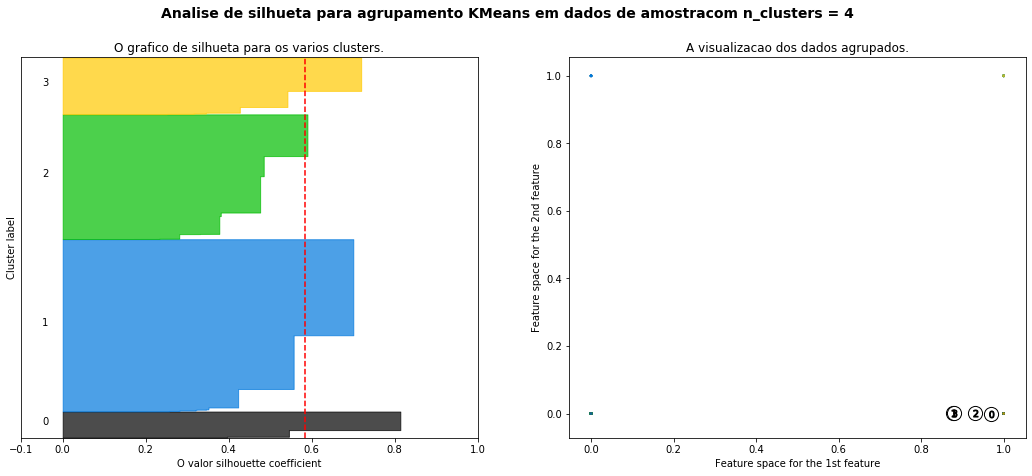

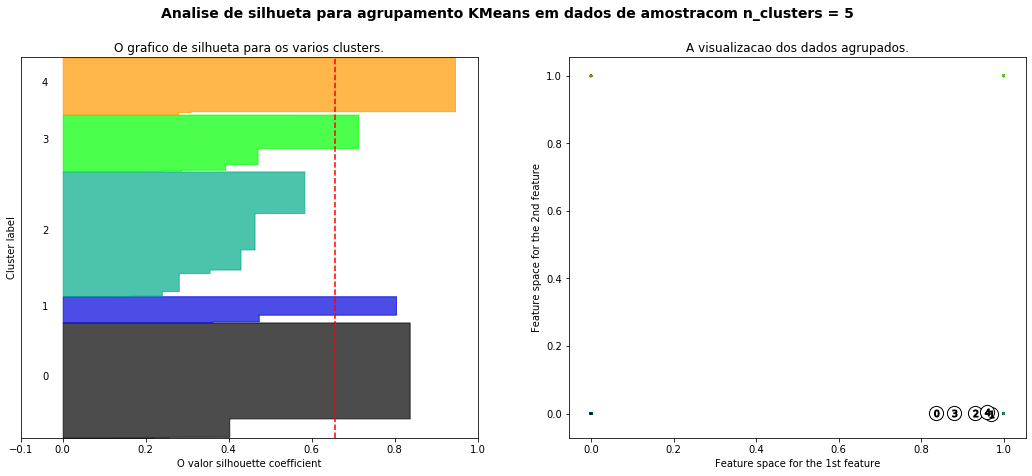

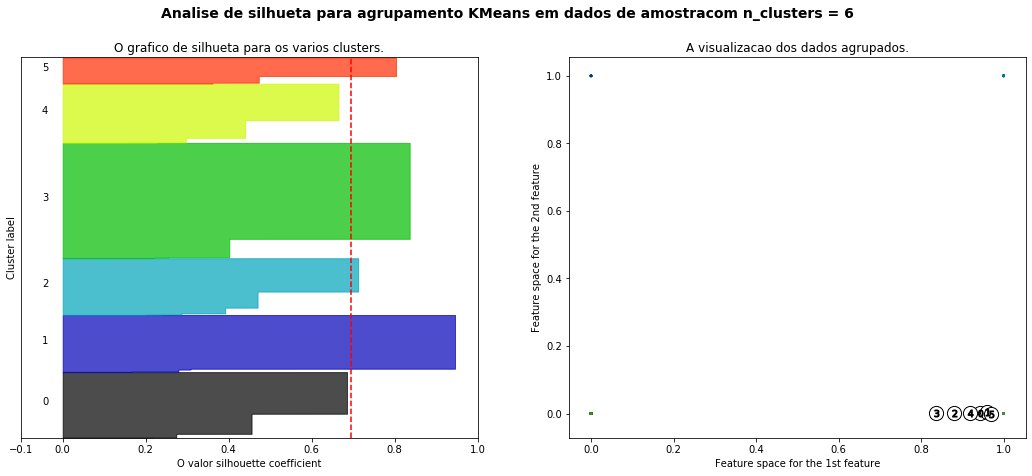

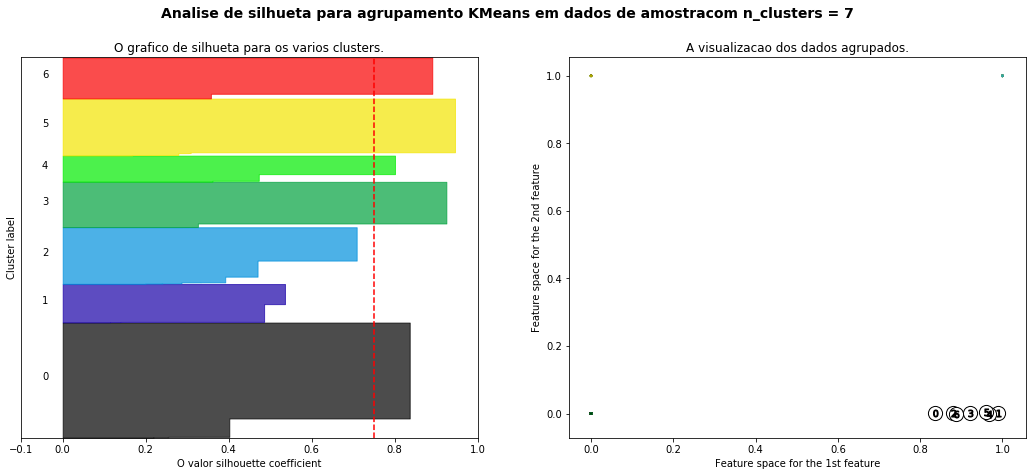

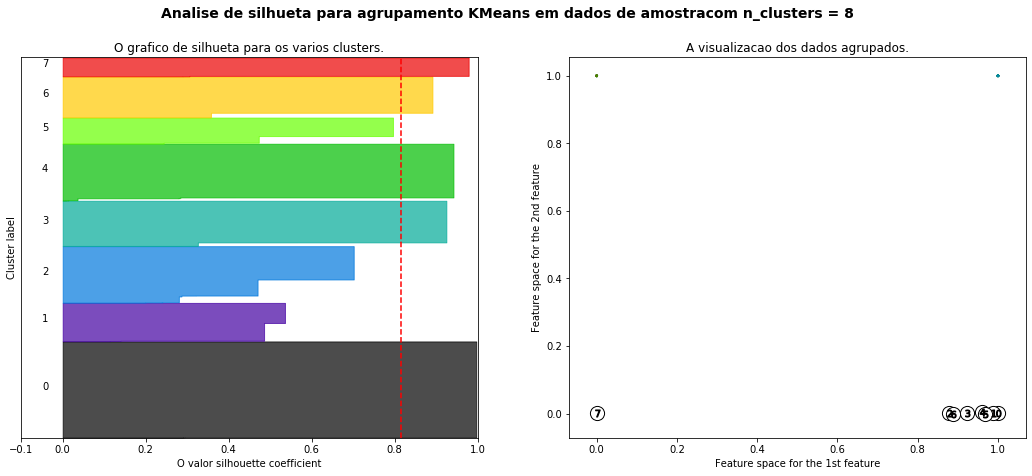

In [133]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans em dados de amostra"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_doenca_{n_clusters}.svg', format="svg")
    #fig.savefig('padrao_doencas/padrao_doencas_kmeans_'+str(n_clusters)+'.png', format='png')  

plt.show()

#fig.savefig('kmeans_padroes_doencas.png', format='png')

In [134]:
#dataset com grupos e por padrão de doencas

dataset_padrao_doenca = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']
#dataset_padrao_doenca = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_padrao_doenca['IMC'] = dataset_medidas['IMC']
dataset_padrao_doenca['grupo'] = grupos
dataset_padrao_doenca['grupo'] = dataset_padrao_doenca['grupo'] + 1

dataset_padrao_doenca = pd.concat([dataset_padrao_doenca,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_padrao_doenca.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

In [135]:
dados_padrao_doencas

,Hipotensao,Sistolica Isolada,Diastolica Isolada,Dipping,Non Dipping,Extreme Dipping,Reverse Dipping,Morning Surge,Masked,Whitecoat,Normotenso
0,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,1,0,0,0,0,1,0
3,1,0,0,1,0,0,0,0,0,1,0
4,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
19556,1,0,0,1,0,0,0,1,0,1,0
19557,1,0,0,0,1,0,0,0,0,1,0
19558,1,0,0,0,1,0,0,0,0,1,0
19559,1,0,0,0,0,1,0,0,0,0,0


## Features Selection: Select Kbest 

In [136]:
#  Uso do SelectKBest para identificar as melhores 5 features

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

features_mais_importante_ml = SelectKBest(chi2, k=5).fit_transform(X, grupos)
features_mais_importante_ml.shape

(19263, 5)

In [137]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

features_mais_importante = pd.DataFrame(features_mais_importante_ml)


In [138]:
# identificação de quais colunas foram escolhidas

lista_colunas_escolhidas = []
# X é o dataset das doenças que precisa ser transformado em df
x_df = pd.DataFrame(X)
for coluna_ml in range(len(features_mais_importante.columns)):
    for coluna_base in range(len(x_df.columns)):
        # para identificar valores únicos
        if set(np.array(x_df[coluna_base]) == np.array(features_mais_importante[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas

# Foram escolhidas as colunas 'Diastolica Isolada', 'Dipping','Non Dipping', 'Extreme Dipping', 'Reverse Dipping'

[3, 4, 5, 6, 7]

In [139]:
#selecionando padrões de doencas

ls_doencas_kbest = ['Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping']

#ls_doencas_kbest = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
#       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
#       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas_kbest =  dataset_apos_tratamento[ls_doencas_kbest]

### K-means para SelectKbest

In [140]:
#  Cálculo do "n_clusters" considerando as colunas definidas por SelectKBest

sum_of_squares = calculate_wcss(features_mais_importante_ml)
n_kbest = optimal_number_of_clusters(sum_of_squares)
kmeans = KMeans(n_clusters=n_kbest, random_state=42).fit(features_mais_importante_ml)
grupos = kmeans.fit_predict(features_mais_importante_ml)
print(n)
print(grupos)

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklea

8
[0 0 1 ... 1 4 0]


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return_n_iter=True)


In [141]:
# Separa o grupo de dados para treino e teste

# Feature Selection: none
#X_train, X_test, y_train, y_test = train_test_split(X, grupos, test_size=0.15, random_state=0)

# Feature Selection: SelectKBest
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)
#
#X_train.shape, y_train.shape
#
#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

###  Abordagem 4: Random Forest

In [142]:
from sklearn.ensemble import RandomForestClassifier

In [143]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=10)

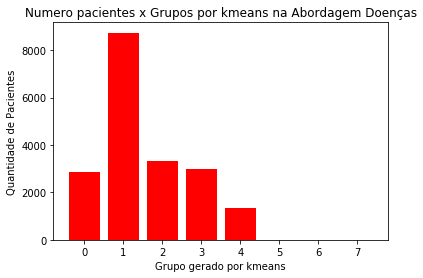

In [144]:
#base para modelo
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()

In [145]:
#salvar a imagem
#fig.savefig('padrao_doencas/qtd_x_padrao_doencas.png', format='png')

## Train, Test, Validation

In [146]:
# Separa o grupo de dados para treino e teste
#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection: none
#X_train, X_test, y_train, y_test = train_test_split(X, grupos, test_size=0.15, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)

# Feature Selection: SelectKBest
x_train, x_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=1 - train_ratio,random_state=42)

# Feature Selection: none
#x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Feature Selection: SelectKBest
x_val, x_test, y_val, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)


# Feature Selection: SelectKBest sem validação
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)

#X_train.shape, y_train.shape

#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [147]:
# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 4: VALIDAÇÃO

In [148]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [149]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [150]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6,7
0,1675,0,0,0,0,0,0,0
1,0,5306,0,0,0,0,0,0
2,0,0,1960,0,0,0,0,0
3,0,0,0,1835,0,0,0,0
4,0,0,0,0,781,0,0,0
5,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0


#### Abordagem 4: TESTE

In [151]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [152]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [153]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

,0,1,2,3,4,5,6,7
0,1203,0,0,0,0,0,0,0
1,0,3431,0,0,0,0,0,0
2,0,0,1369,0,0,0,0,0
3,0,0,0,1162,0,0,0,0
4,0,0,0,0,541,0,0,0
5,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0


In [154]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

####  Abordagem 4: Importância das Features Random Forest

In [155]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

#importancia = pd.DataFrame({'features':ls_padroes_doencas,'importance':np.round(random_forest.feature_importances_,3)})

# Importância para SelctKBest
importancia = pd.DataFrame({'features':ls_doencas_kbest,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False).set_index('features')



In [156]:
importancia

,importance
features,
Dipping,0.312
Reverse Dipping,0.238
Diastolica Isolada,0.201
Extreme Dipping,0.143
Non Dipping,0.106


In [157]:
importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')


In [158]:
# Troca valores 0 e 1 para F e M 
ajusta_coluna_genero = {"genero": {1: "M", 0:"F"}}
dataset_apos_tratamento = dataset_apos_tratamento.replace(ajusta_coluna_genero)

#  Grava dataset tratado
#dataset_apos_tratamento.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_aceitos_apos_tratamento_dados.csv', 
#             sep=';',index=False,encoding='UTF-8')

## Abordagem de cada doença

In [159]:
ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_medidas = list(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'].columns)

#  O índice zero é a 1a. coluna de doença que vai até 9 (a últim até Whitecoat)
grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

dados_medidas_novo = np.array(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'])
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = [0,1]
qtds = []

'''contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()'''
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_novo, grupos_doenca, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_novo, grupos_doenca, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

#### Abordagem 4: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 0.9999134723544172 - Recall: 0.9995559502664298 - F1 Score: 0.9997539106267362


,0,1
0,1125,1
1,0,10431


In [160]:
#### Abordagem 4: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 0.9488710096029068 - Recall: 0.7867963576776094 - F1 Score: 0.8342702707187544


,0,1
0,452,322
1,72,6860


In [161]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dados_medidas_novo, grupos_doenca, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dados_medidas_novo, grupos_doenca, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

##validacao
#pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
#pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
#pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
#pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
#             sep=';',index=False,encoding='UTF-8')

##teste
#pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
#pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
#pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
#pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
#             sep=';',index=False,encoding='UTF-8')


####  Abordagem 4: Importância das Features Random Forest

#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

#importancia = pd.DataFrame({'features':ls_padroes_doencas,'importance':np.round(random_forest.feature_importances_,3)})

# Importância para SelctKBest
importancia = pd.DataFrame({'features':ls_medidas,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False).set_index('features')


importancia

,importance
features,
diast 3:00,0.023
diast 3:30,0.023
diast 1:30,0.019
diast 2:30,0.017
diast 2:00,0.017
...,...
sist 9:15,0.004
sist 8:45,0.004
sist 8:30,0.004


# Abordagem por Categorias 

In [162]:
#convertendo os dados para entrga ao Random - Classifcação

#ls_classes = list(dataset_por_classes.loc[:,'genero':].columns)

ls_classes = list((dataset_por_classes.drop(list(dataset_por_classes.loc[:,'sist 9:00':'diast 8:45'].columns),axis=1)).drop('numero_identificacao',axis=1).columns)

array_classes = np.array(dataset_por_classes[ls_classes])

#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(array_classes)
n_classes = optimal_number_of_clusters(sum_of_squares)
print (n_classes)

8


In [163]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans_classes = KMeans(n_clusters=n_classes, random_state=42).fit(array_classes)


#listar os grupos 

grupos_classes = kmeans_classes.fit_predict(array_classes)


grupos_classes

array([5, 5, 1, ..., 1, 0, 5])

In [164]:
#  Inclui a coluna Grupo no dataset que será gravado no final
dataset_por_classes['grupo'] = grupos_classes 
dataset_por_classes['grupo'] = dataset_por_classes['grupo'] + 1

In [165]:
print (len(grupos_classes))

19263


In [166]:
set(grupos_classes)

{0, 1, 2, 3, 4, 5, 6, 7}

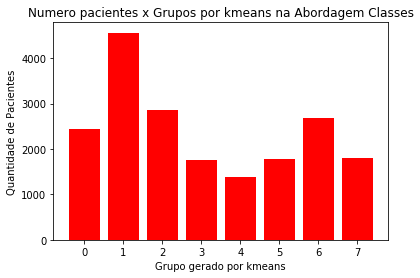

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


,0,1,2,3,4,5,6,7
0,1438,0,0,0,0,0,0,0
1,0,2771,0,0,0,0,0,0
2,0,0,1737,0,0,0,0,0
3,0,0,0,1057,0,0,0,0
4,0,0,0,0,834,0,0,0
5,0,0,0,0,0,1033,0,0
6,0,0,0,0,0,0,1632,0
7,0,0,0,0,0,0,0,1055


In [167]:


from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest_classes = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = []
qtds = []

contagem = Counter(grupos_classes)

for i in range(0,n_classes):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Classes')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_AbordagemClasses_doenca_por_grupos.svg',format="svg")
plt.show()


train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(array_classes, grupos_classes, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(array_classes, grupos_classes, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest_classes.fit(x_train, y_train)

#### Abordagem 4: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest_classes.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

In [168]:
#### Abordagem 4: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest_classes.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 0.9993511549441993 - Recall: 0.9990205567994876 - F1 Score: 0.9990762437340932


,0,1,2,3,4,5,6,7
0,1003,0,0,0,0,0,0,0
1,0,1791,0,0,0,0,0,0
2,0,0,1127,0,0,0,0,0
3,0,0,0,693,0,0,0,0
4,0,0,0,0,536,3,0,0
5,0,0,0,0,0,740,0,0
6,0,0,0,1,0,0,1057,0
7,0,0,0,1,0,0,0,754


In [169]:
# Importância para Categorias

importancia = pd.DataFrame({'features':ls_classes,'importance':np.round(random_forest_classes.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False).set_index('features')


importancia

,importance
features,
IMC,0.435
idade,0.282
Dipping,0.109
Non Dipping,0.084
Reverse Dipping,0.039
Morning Surge,0.029
Extreme Dipping,0.013
genero,0.005
Hipotensao,0.001


##  Grava arquivo da abordagem 1 - Cadastro e Medidas

In [170]:
def gera_arquivos_por_grupo(todos_dados_grupo):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_cadastro_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)


#gera_arquivos_por_grupo(todos_dados_grupo)

In [171]:
dados_completos_cadastro = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

In [172]:
dados_completos_cadastro[dados_completos_cadastro['grupo'] == 2]

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,grupo,data_exame,sist 9:00,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
4,8,1990-03-07,M,28.0,120.0,172,40.6,2,2018-12-26 08:26:59,113.0,...,115.0,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11
10,14,1932-05-28,F,86.0,59.0,149,26.6,2,2018-12-26 10:06:10,107.0,...,108.0,66.0,8810.5,5280.5,2900.5,574.0,8.15,7.86,11,16
18,23,1956-09-01,F,62.0,73.0,160,28.5,2,2018-12-26 10:29:28,122.0,...,104.0,61.0,8597.0,5037.0,2987.5,540.0,14.21,10.31,25,35
29,35,1964-11-28,M,54.0,74.0,"1,58",29.6,2,2018-12-26 15:14:33,130.0,...,127.0,90.0,10380.0,7101.0,2744.0,501.5,19.03,14.79,21,36
33,40,1962-01-01,M,56.0,85.0,"1,77",27.1,2,2018-12-26 16:19:28,122.0,...,122.0,80.0,9861.5,6198.0,3103.5,523.5,10.69,8.57,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19526,21749,1964-10-23,F,55.0,83.0,161,32.0,2,2020-09-10 10:18:56,112.0,...,112.0,69.0,8987.5,5536.5,2843.5,550.5,11.09,11.33,16,25
19537,21760,1983-05-27,M,37.0,89.0,175,29.1,2,2020-09-10 11:24:21,126.0,...,125.0,89.0,10436.5,7411.0,2493.5,483.0,19.39,17.25,19,31
19539,21763,1976-09-02,M,44.0,91.0,176,29.4,2,2020-09-10 11:32:47,118.0,...,117.0,82.0,9464.5,6347.0,2593.0,503.0,9.75,11.20,8,14
19540,21764,1992-08-28,F,28.0,70.0,"1,60",27.3,2,2020-09-10 11:41:43,121.0,...,110.0,75.0,8776.5,6001.5,2242.0,499.0,11.44,11.77,18,14


In [173]:
gera_arquivos_por_grupo(dados_completos_cadastro)

###  Grava arquivo da abordagem 2 - Medidas

In [174]:
def gera_arquivos_por_grupo(todos_dados_grupo):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS /  f"KMEANS_approach_medidas_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)

#gera_arquivos_por_grupo(todos_dados_grupo)

In [175]:
dados_completos_medidas = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_medidas_sem_id['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

In [176]:
dados_completos_medidas[dados_completos_medidas['grupo'] == 6]

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,grupo,data_exame,sist 9:00,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
12,17,1976-05-20,M,42.0,87.0,175,28.4,6,2018-12-26 10:12:44,145.0,...,132.5,88.5,10621.0,7194.0,2801.0,610.0,17.55,14.13,20,26
13,18,1953-04-18,F,65.0,72.0,172,24.3,6,2018-12-26 10:15:40,142.0,...,139.0,87.0,11003.5,6952.5,3237.0,735.5,18.78,14.23,37,28
29,35,1964-11-28,M,54.0,74.0,"1,58",29.6,6,2018-12-26 15:14:33,130.0,...,127.0,90.0,10380.0,7101.0,2744.0,501.5,19.03,14.79,21,36
35,42,1969-10-11,F,49.0,74.0,"1,63",27.9,6,2018-12-26 17:28:58,111.0,...,125.0,88.0,10280.5,7302.0,2422.5,512.0,12.74,12.18,4,22
46,54,1989-09-10,M,29.0,108.0,177,34.5,6,2018-12-27 09:02:36,145.0,...,129.0,92.0,10436.5,7109.5,2630.5,617.5,11.15,12.63,11,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19504,21724,1981-08-18,M,39.0,76.0,"1,83",22.7,6,2020-09-09 16:40:41,144.0,...,130.0,93.0,10549.5,7295.0,2699.5,513.5,11.54,12.73,13,37
19528,21751,1982-01-15,M,38.0,90.0,171,30.8,6,2020-09-10 10:25:06,115.0,...,135.0,89.5,11076.5,7272.5,3190.0,576.5,15.85,12.77,32,41
19537,21760,1983-05-27,M,37.0,89.0,175,29.1,6,2020-09-10 11:24:21,126.0,...,125.0,89.0,10436.5,7411.0,2493.5,483.0,19.39,17.25,19,31
19538,21762,2020-08-04,M,0.0,85.0,180,26.2,6,2020-09-10 11:30:59,146.0,...,149.0,94.0,11686.0,7355.5,3626.0,646.0,15.99,10.62,52,52


In [177]:
gera_arquivos_por_grupo(dados_completos_medidas)

###  Grava arquivo da abordagem 3 - Estatísticas

In [178]:
def gera_arquivos_por_grupo(todos_dados_grupo):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_estatistica_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)

#gera_arquivos_por_grupo(todos_dados_grupo)

In [179]:
dados_completos_estatistica = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_estatistica_sem_nan['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

In [180]:
gera_arquivos_por_grupo(dados_completos_estatistica)

###   Grava arquivo da abordagem 4 - DOENÇAS

In [181]:
def gera_arquivos_por_grupo(todos_dados_grupo):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        print(df_grupo)
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_doenca_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)

#gera_arquivos_por_grupo(todos_dados_grupo)

In [182]:
dados_completos_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

In [183]:
gera_arquivos_por_grupo(dados_completos_doenca)

       numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
5                         9      1982-04-28      M   36.0  100.0    185  29.2   
6                        10      1965-09-18      M   53.0   89.0    174  29.4   
13                       18      1953-04-18      F   65.0   72.0    172  24.3   
14                       19      1981-12-16      M   37.0   85.0    164  31.6   
...                     ...             ...    ...    ...    ...    ...   ...   
19549                 21774      1947-12-10      F   72.0   72.0    161  27.8   
19550                 21775      1955-09-04      M   65.0   94.0   1,83  28.1   
19552                 21779      1947-04-19      F   73.0   71.0    159  28.1   
19557                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19558                 21788      1985-03-15      F   35.0   93.0    167  33.3   

       grupo           data

       numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
9                        13      1963-06-23      F   55.0   60.0    158  24.0   
36                       43      1991-06-13      F   27.0  113.0   1,62  43.1   
45                       53      1960-12-20      M   58.0   74.0    174  24.4   
47                       55      1963-09-02      M   55.0  101.0    170  34.9   
53                       61      1955-09-18      F   63.0   65.0    160  25.4   
...                     ...             ...    ...    ...    ...    ...   ...   
19525                 21748      1976-12-24      M   43.0  122.0   1,82  36.8   
19528                 21751      1982-01-15      M   38.0   90.0    171  30.8   
19529                 21752      1988-03-11      F   32.0   90.0   1,62  34.3   
19535                 21758      1952-12-19      F   67.0   65.0   1,58  26.0   
19556                 21786      1972-11-25      M   47.0   75.0    165  27.5   

       grupo           data

       numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
39                       47      1987-01-30      F   31.0   76.0    180  23.5   
41                       49      1959-04-29      M   59.0  100.0    183  29.9   
49                       57      1949-12-09      F   69.0   61.0    159  24.1   
50                       58      1967-03-24      M   51.0   78.0    172  26.4   
68                       77      1949-05-28      M   69.0   78.0   1,56  32.1   
...                     ...             ...    ...    ...    ...    ...   ...   
19543                 21767      1968-11-15      F   51.0   75.0    165  27.5   
19544                 21768      1964-09-26      F   55.0   71.0    157  28.8   
19553                 21781      1947-04-18      F   73.0   92.0    168  32.6   
19555                 21783      1969-05-24      M   51.0   93.0    168  33.0   
19559                 21792      1952-04-21      F   68.0   64.0    160  25.0   

       grupo           data

       numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
3                         7      1978-01-26      F   40.0   65.0   1,64  24.2   
17                       22      1962-06-19      F   56.0   80.0    155  33.3   
22                       27      1990-05-26      M   28.0  140.0    177  44.7   
25                       30      1955-06-17      M   63.0   68.0    164  25.3   
32                       39      1983-07-31      M   35.0  110.0   1,83  32.8   
...                     ...             ...    ...    ...    ...    ...   ...   
19476                 21690      1967-08-23      M   53.0   95.0   1,75  31.0   
19481                 21695      1973-12-01      M   46.0   73.0    168  25.9   
19497                 21713      1964-02-23      F   56.0   81.0    157  32.9   
19524                 21747      1953-01-20      M   67.0   69.0    167  24.7   
19531                 21754      1953-12-20      F   66.0   68.0    158  27.2   

       grupo           data

In [184]:
dataset = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')

In [185]:
arquivo_whitecoat = pd.concat([dataset[dataset['Whitecoat'] == True].loc[:,'numero_identificacao'],
                               dataset[dataset['Whitecoat'] == True].loc[:,'Whitecoat']],axis=1)

arquivo_whitecoat.to_csv(DIR_KMEANS / "KMEANS_validando_whitecoat.csv", 
                        sep=";", encoding="latin1", index=False)

###   Grava arquivo da abordagem 5 -  CATEGORIAS

In [186]:
def gera_arquivos_por_grupo(todos_dados_grupo):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_classes_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)


#gera_arquivos_por_grupo(todos_dados_grupo)

In [187]:
dados_completos_classes = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dataset_por_classes['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

In [188]:
gera_arquivos_por_grupo(dados_completos_classes)